In [1]:
from matplotlib import pyplot as plt
import h5py
import numpy as np
from tqdm import *
from scipy import spatial
import matplotlib.gridspec as gridspec
import stats
import os
import subprocess
from zipfile import ZipFile

# Calculate Jackknife error bars
### Start with Figure 3 in the Astro 98 paper

C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


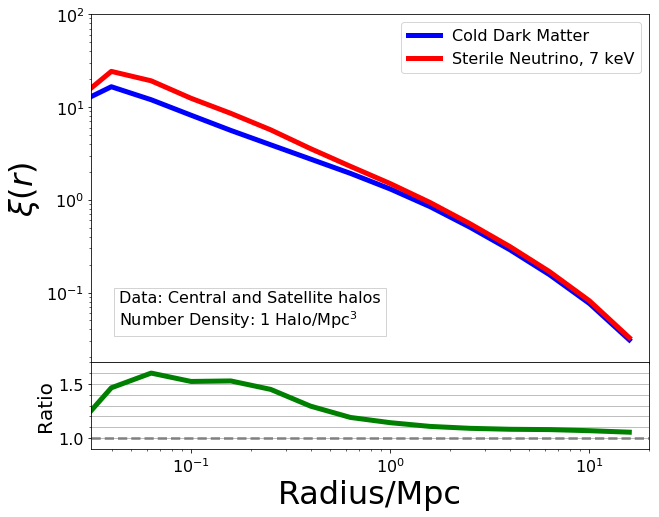

In [2]:
CUTE_cdm_sorted = np.genfromtxt("Output/corr_cdm_pos_sorted.txt", usecols = (0,1))
CUTE_wdm_sorted = np.genfromtxt("Output/corr_wdm_pos_sorted.txt", usecols = (0,1))

textstr = '\n'.join((
    r'Data: Central and Satellite halos',
    r'Number Density: 1 Halo/Mpc$^{3}$'))
props = dict(facecolor='none', edgecolor='lightgrey', pad = 5.0)

plt.figure(figsize=(10,8))
grid = gridspec.GridSpec(2,1, height_ratios = [4,1])
grid.update(hspace = 0)
grid0 = plt.subplot(grid[0])
grid1 = plt.subplot(grid[1])

grid0.loglog(CUTE_cdm_sorted[:,0], CUTE_cdm_sorted[:,1], label = "Cold Dark Matter", linewidth = 5, 
             color = "blue")
grid0.loglog(CUTE_wdm_sorted[:,0], CUTE_wdm_sorted[:,1], label = "Sterile Neutrino, 7 keV", linewidth = 5, 
             color = "red")
grid0.set_xlim(10**-1.5, 2e1)
grid0.set_ylim(10**-1.75, 10**2)
grid0.set_ylabel(r"$\xi(r)$", fontsize = 32)
grid0.legend(fontsize=16)
grid0.minorticks_on()
grid0.tick_params(labelsize=16)
grid0.text(0.05, 0.2, textstr, transform=grid0.transAxes, fontsize=16, verticalalignment='top', bbox=props)

grid1.semilogx(CUTE_wdm_sorted[:,0], CUTE_wdm_sorted[:,1]/CUTE_cdm_sorted[:,1], linewidth = 5, color = "green")
grid1.set_xlabel("Radius/Mpc", fontsize = 32)
grid1.set_ylabel("Ratio",  fontsize = 20)
grid1.axhline(y = 1, color = "grey", ls = "--", linewidth = 2.5)
grid1.set_xlim(10**-1.5, 2e1)
grid1.set_ylim(0.9, 1.7)
grid1.minorticks_on()
grid1.tick_params(labelsize=16)
grid1.yaxis.grid(which = "both")

plt.show()

### Split the halos into 27 subvolumes (cubes)

In [3]:
def sublength(position,i):
    length = 100/3 # Mpc
    
    ind1=np.where(position[:,i]<length)[0]
    ind2=np.where((position[:,i]>length) & (position[:,i]<2*length))[0]
    ind3=np.where(position[:,i]>2*length)[0]
    
    return [ind1,ind2,ind3]

def subvolume(position,ind,i):
    n,volume_ind=3,[[],[],[]]
    for j in range(n):
        for k in range(n):
            volume_ind[j].append(ind[j][sublength(position[ind[j]],i)[k]])
    return volume_ind

def subvolume_ind(position):
    
    #split along the x-direction
    subvolume_ind=sublength(position,0)

    #split along the y-direction
    subvolume_ind=subvolume(position,subvolume_ind,1)

    #split along the z-direction
    return [subvolume(position,subvolume_ind[0],2),
            subvolume(position,subvolume_ind[1],2),
            subvolume(position,subvolume_ind[2],2)]

# obtain 27 subsamples by deleting each subvolume
def subsample(file,loc,folder='Input'):        
    
    # Create an input folder 
    directory='C:\\Users\\shife\\OneDrive\\Harvard_Stuff\\Astro_98'
    if not os.path.exists(directory+'\\Input\\jackknife'):
        os.mkdir(directory+'\\Input\\jackknife')
        
    # Access the halo positions for wdm/cdm
    cdm_position = np.genfromtxt(directory+'\\'+folder+'\\cdm_'+file+'.txt')
    wdm_position = np.genfromtxt(directory+'\\'+folder+'\\wdm_'+file+'.txt')
    
    # Access the halo indices in each subvolume
    cdm_subvolume_ind=subvolume_ind(cdm_position)
    wdm_subvolume_ind=subvolume_ind(wdm_position)
        
    # Delete each subvolume to create each subsample
    n,cdm_subsample,wdm_subsample=3,[[[],[],[]],[[],[],[]],[[],[],[]]],[[[],[],[]],[[],[],[]],[[],[],[]]]
    for i in range(n):
        for j in range(n):
            for k in range(n):
                cdm_subsample[i][j].append(np.delete(cdm_position,cdm_subvolume_ind[i][j][k],axis=0))
                wdm_subsample[i][j].append(np.delete(wdm_position,wdm_subvolume_ind[i][j][k],axis=0))

                root="_subsample_"+str(i)+str(j)+str(k)+".txt"
                np.savetxt(directory+'\\Input\\jackknife\\cdm'+root, cdm_subsample[i][j][k], fmt = "%f %f %f")
                np.savetxt(directory+'\\Input\\jackknife\\wdm'+root, wdm_subsample[i][j][k], fmt = "%f %f %f")
                
    # Zip each input file
    os.chdir(directory+'\\Input\\jackknife')
    for zip_file in [file for file in os.listdir() if file.endswith(".txt")]:
        subprocess.call(['zip','-ur',loc+'.zip',zip_file])
    os.chdir(directory)

In [4]:
# Send it to odyssey
file='pos_sorted'
subsample(file,'jackknife_'+file)

### Define a function to plot the correlation function with the jackknife error bars!

In [5]:
def stddev(var,N=27):
    return np.sqrt(((N-1)/N)*np.sum(var,axis=0))
    
def jackknife(loc):
    
    # Create an output folder 
    directory,n='C:\\Users\\shife\\OneDrive\\Harvard_Stuff\\Astro_98',3
    if not os.path.exists(directory+'\\Output\\jackknife'):
        os.mkdir(directory+'\\Output\\jackknife')
        
    # unzip the zip file
    if os.path.exists(directory+'\\Output\\'+loc+'.zip'):
        if os.path.exists(directory+'\\Output\\jackknife\\'+loc+'.zip'):
            os.remove(directory+'\\Output\\jackknife\\'+loc+'.zip')
        os.rename(directory+'\\Output\\'+loc+'.zip',directory+'\\Output\\jackknife\\'+loc+'.zip')
    with ZipFile(directory+'\\Output\\jackknife\\'+loc+'.zip', 'r') as zip_ref:
        zip_ref.extractall(directory+'\\Output\\jackknife')
    
    # load the files from odyssey
    CUTE_cdm_jackknife,CUTE_wdm_jackknife=[[[],[],[]],[[],[],[]],[[],[],[]]],[[[],[],[]],[[],[],[]],[[],[],[]]]
    for i in range(n):
        for j in range(n):
            for k in range(n):
                file="_subsample_"+str(i)+str(j)+str(k)+".txt"
                CUTE_cdm_jackknife[i][j].append(np.genfromtxt(directory+"\\Output\\jackknife\\corr_cdm"+file))
                CUTE_wdm_jackknife[i][j].append(np.genfromtxt(directory+"\\Output\\jackknife\\corr_wdm"+file))
            
    # calculate the correlation function for each subsample  
    xi_cdm,xi_wdm,xi_ratio,var_cdm,var_wdm,var_ratio=[],[],[],[],[],[]   
    for i in range(n):
        for j in range(n):
            for k in range(n):
                xi_cdm.append((CUTE_cdm_jackknife[i][j][k][:,1]))
                xi_wdm.append((CUTE_wdm_jackknife[i][j][k][:,1]))                      
                xi_ratio.append((CUTE_wdm_jackknife[i][j][k][:,1]/CUTE_cdm_jackknife[i][j][k][:,1]))          

    # calculate the variance of each subvolume from the mean
    xi_cdm,xi_wdm,xi_ratio=np.mean(xi_cdm,axis=0),np.mean(xi_wdm,axis=0),np.mean(xi_ratio,axis=0)
    for i in range(n):
        for j in range(n):
            for k in range(n):
                var_cdm.append(((CUTE_cdm_jackknife[i][j][k][:,1]-xi_cdm)**2))
                var_wdm.append(((CUTE_wdm_jackknife[i][j][k][:,1]-xi_wdm)**2))
                var_ratio.append(((CUTE_wdm_jackknife[i][j][k][:,1]/
                                   CUTE_cdm_jackknife[i][j][k][:,1]-xi_ratio)**2))            
    
    # return the jackknife standard deviation
    return stddev(var_cdm),stddev(var_wdm),stddev(var_ratio)

def plot(file,textstr,xlim=[5*10**-3,2e1],ylim=[10**-1.25,10**5.5],ylim_ratio=[0.8125,1.375],save=False):

    CUTE_cdm_sorted = np.genfromtxt("Output/corr_cdm_"+file+".txt", usecols = (0,1))
    CUTE_wdm_sorted = np.genfromtxt("Output/corr_wdm_"+file+".txt", usecols = (0,1))
    
    cdm_jackknife,wdm_jackknife,ratio_jackknife=jackknife('jackknife_'+file)
    
    props = dict(facecolor='none', edgecolor='lightgrey', pad = 5.0)

    plt.figure(figsize=(10,8))
    grid = gridspec.GridSpec(2,1, height_ratios = [4,1])
    grid.update(hspace = 0)
    grid0 = plt.subplot(grid[0])
    grid1 = plt.subplot(grid[1])

    grid0.errorbar(CUTE_cdm_sorted[:,0], CUTE_cdm_sorted[:,1], yerr = cdm_jackknife, capsize = 5, 
                   capthick = 5, label = "Cold Dark Matter", linewidth = 5, color = "blue")
    grid0.errorbar(CUTE_wdm_sorted[:,0], CUTE_wdm_sorted[:,1], yerr = wdm_jackknife, capsize = 5, 
                   capthick = 5, label = "Sterile Neutrino, 7 keV", linewidth = 5, color = "red")
    grid0.text(0.05, 0.2, textstr, transform=grid0.transAxes, fontsize=16, verticalalignment='top', bbox=props)
    grid0.set_ylabel(r"$\xi(r)$", fontsize = 32)
    grid0.set_xlim(xlim[0],xlim[1])
    grid0.set_ylim(ylim[0],ylim[1])
    grid0.set_xscale('Log')
    grid0.set_yscale('Log')
    grid0.tick_params(labelsize=16)
    grid0.legend(fontsize=16)
    grid0.minorticks_on()

    grid1.errorbar(CUTE_wdm_sorted[:,0], CUTE_wdm_sorted[:,1]/CUTE_cdm_sorted[:,1], yerr = ratio_jackknife, 
                   capsize = 5, capthick = 5, linewidth = 5, color = "green")
    grid1.axhline(y = 1, color = "grey", ls = "--", linewidth = 2.5)
    grid1.set_xlabel("Radius/Mpc", fontsize = 32)
    grid1.set_ylabel("Ratio",  fontsize = 20)
    grid1.set_xlim(xlim[0],xlim[1])
    grid1.set_ylim(ylim_ratio[0],ylim_ratio[1]) #0.9, 1.35 #0.9, 1.5
    grid1.set_xscale('Log')
    grid1.yaxis.grid(which = "both")
    grid1.tick_params(labelsize=16)
    grid1.minorticks_on()

    if save==True:
        plt.savefig('Images/Summer2020/'+file+'.pdf')
    plt.show()

C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in true_divide


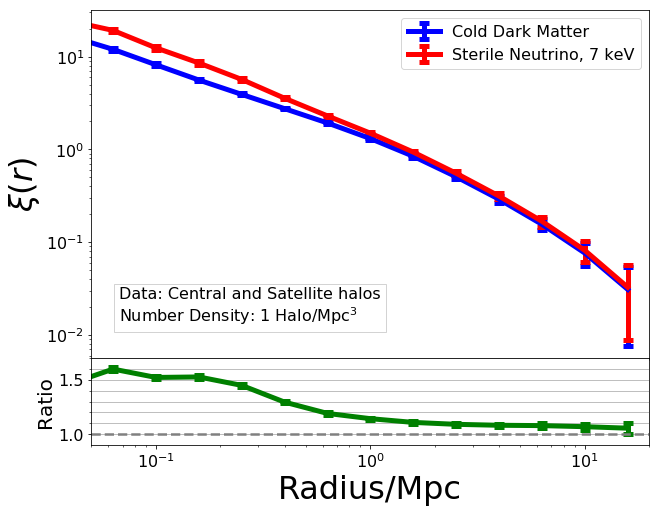

In [6]:
# plot the figure
file='pos_sorted'
textstr = '\n'.join((
    r'Data: Central and Satellite halos',
    r'Number Density: 1 Halo/Mpc$^{3}$'))
plot(file,textstr,xlim=[0.5*10**-1,2e1],ylim=[10**-2.25,10**1.5],ylim_ratio=[0.9, 1.7],save=True)

### Repeat for all the correlation function figures in the Astro 98 paper: Next is Figure 4

C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


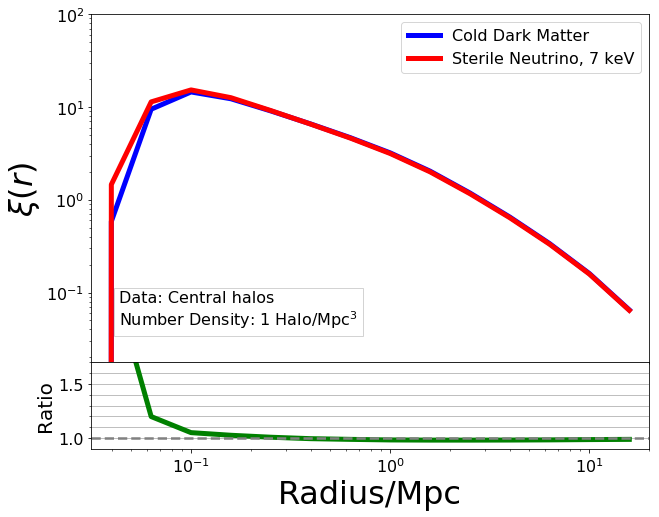

In [7]:
CUTE_cdm_sorted = np.genfromtxt("Output/corr_cdm_pos_sorted_centrals.txt", usecols = (0,1))
CUTE_wdm_sorted = np.genfromtxt("Output/corr_wdm_pos_sorted_centrals.txt", usecols = (0,1))

textstr = '\n'.join((
    r'Data: Central halos',
    r'Number Density: 1 Halo/Mpc$^{3}$'))
props = dict(facecolor='none', edgecolor='lightgrey', pad = 5.0)

plt.figure(figsize=(10,8))
grid = gridspec.GridSpec(2,1, height_ratios = [4,1])
grid.update(hspace = 0)
grid0 = plt.subplot(grid[0])
grid1 = plt.subplot(grid[1])

grid0.loglog(CUTE_cdm_sorted[:,0], CUTE_cdm_sorted[:,1], label = "Cold Dark Matter", linewidth = 5, 
             color = "blue")
grid0.loglog(CUTE_wdm_sorted[:,0], CUTE_wdm_sorted[:,1], label = "Sterile Neutrino, 7 keV", linewidth = 5, 
             color = "red")
grid0.set_xlim(10**-1.5, 2e1)
grid0.set_ylim(10**-1.75, 10**2)
grid0.set_ylabel(r"$\xi(r)$", fontsize = 32)
grid0.legend(fontsize = 16)
grid0.minorticks_on()
grid0.tick_params(labelsize=16)
grid0.text(0.05, 0.2, textstr, transform=grid0.transAxes, fontsize=16, verticalalignment='top', bbox=props)

grid1.semilogx(CUTE_wdm_sorted[:,0], CUTE_wdm_sorted[:,1]/CUTE_cdm_sorted[:,1], linewidth = 5, color = "green")
grid1.set_xlabel("Radius/Mpc", fontsize = 32)
grid1.set_ylabel("Ratio", fontsize=20)
grid1.axhline(y = 1, color = "grey", ls = "--", linewidth = 2.5)
grid1.set_xlim(10**-1.5, 2e1)
grid1.set_ylim(0.9, 1.7)
grid1.minorticks_on()
grid1.tick_params(labelsize=16)
grid1.yaxis.grid(which = "both")

plt.show()

In [8]:
# Send it to odyssey
file='pos_sorted_centrals'
subsample(file,'jackknife_'+file)

C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in subtract
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in true_divide


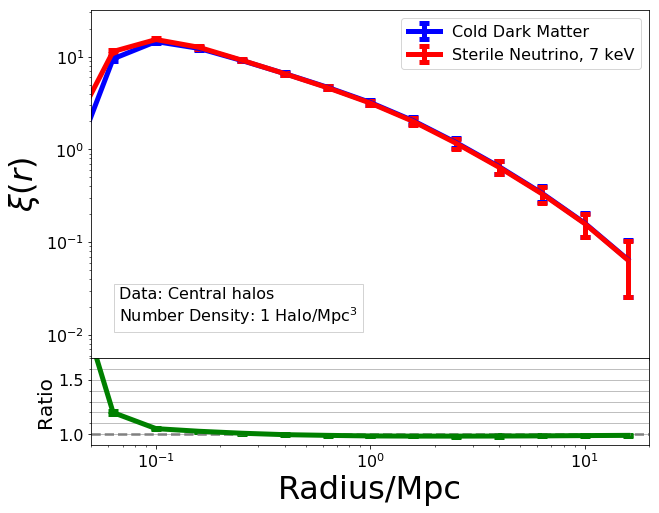

In [9]:
# plot the figure
file='pos_sorted_centrals'
textstr = '\n'.join((
    r'Data: Central halos',
    r'Number Density: 1 Halo/Mpc$^{3}$'))
plot(file,textstr,xlim=[0.5*10**-1,2e1],ylim=[10**-2.25,10**1.5],ylim_ratio=[0.9, 1.7],save=True)

### Figure 6

C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


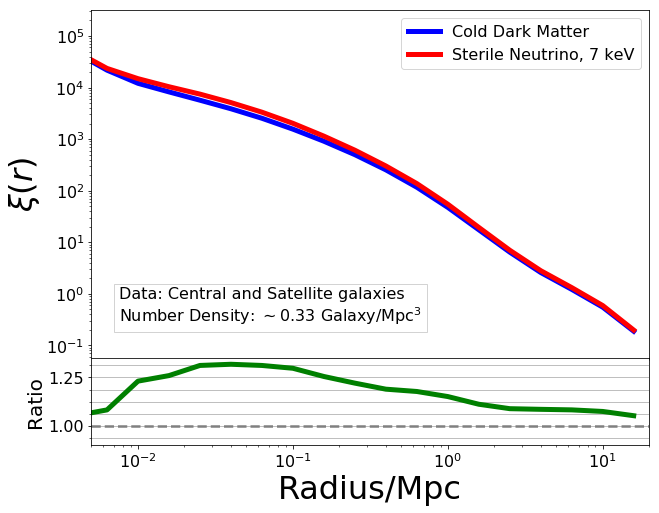

In [10]:
CUTE_cdm_sorted = np.genfromtxt("Output/corr_cdm_galaxy2.txt", usecols = (0,1))
CUTE_wdm_sorted = np.genfromtxt("Output/corr_wdm_galaxy2.txt", usecols = (0,1))

textstr = '\n'.join((
    r'Data: Central and Satellite galaxies',
    r'Number Density: $\sim$0.33 Galaxy/Mpc$^{3}$'))
props = dict(facecolor='none', edgecolor='lightgrey', pad = 5.0)

plt.figure(figsize=(10,8))
grid = gridspec.GridSpec(2,1, height_ratios = [4,1])
grid.update(hspace = 0)
grid0 = plt.subplot(grid[0])
grid1 = plt.subplot(grid[1])

grid0.loglog(CUTE_cdm_sorted[:,0], CUTE_cdm_sorted[:,1], label = "Cold Dark Matter", linewidth = 5, 
             color = "blue")
grid0.loglog(CUTE_wdm_sorted[:,0], CUTE_wdm_sorted[:,1], label = "Sterile Neutrino, 7 keV", linewidth = 5, 
             color = "red")
grid0.set_xlim(5*10**-3, 2e1)
grid0.set_ylim(10**-1.25, 10**5.5)
grid0.set_ylabel(r"$\xi(r)$", fontsize = 32)
grid0.legend(fontsize = 16)
grid0.minorticks_on()
grid0.tick_params(labelsize=16)
grid0.text(0.05, 0.2, textstr, transform=grid0.transAxes, fontsize=16, verticalalignment='top', bbox=props)

grid1.semilogx(CUTE_wdm_sorted[:,0], CUTE_wdm_sorted[:,1]/CUTE_cdm_sorted[:,1], linewidth = 5, color = "green")
grid1.set_xlabel("Radius/Mpc", fontsize = 32)
grid1.set_ylabel("Ratio", fontsize = 20)
grid1.axhline(y = 1, color = "grey", ls = "--", linewidth = 2.5)
grid1.set_xlim(5*10**-3, 2e1)
grid1.set_ylim(0.9, 1.35)
grid1.minorticks_on()
grid1.tick_params(labelsize=16)
grid1.yaxis.grid(which = "both")

plt.show()

In [11]:
# Send it to odyssey
file='galaxy2'
subsample(file,'jackknife_'+file)

C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in subtract
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in true_divide


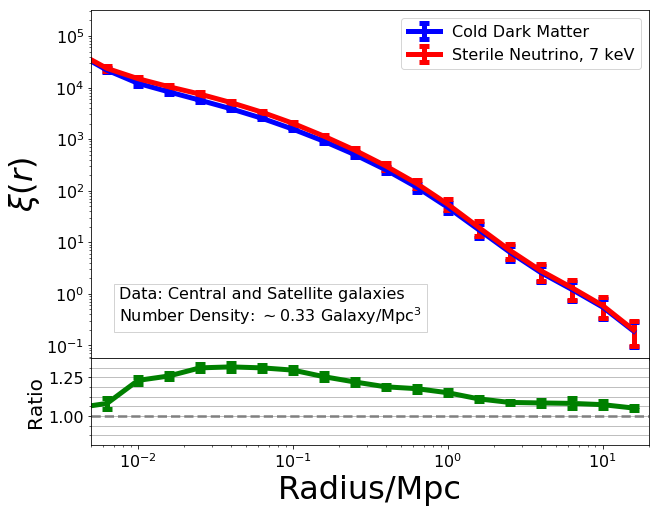

In [12]:
# plot the figure
file='galaxy2'
textstr = '\n'.join((
    r'Data: Central and Satellite galaxies',
    r'Number Density: $\sim$0.33 Galaxy/Mpc$^{3}$'))
plot(file,textstr,save=True)

### Figure 7

C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


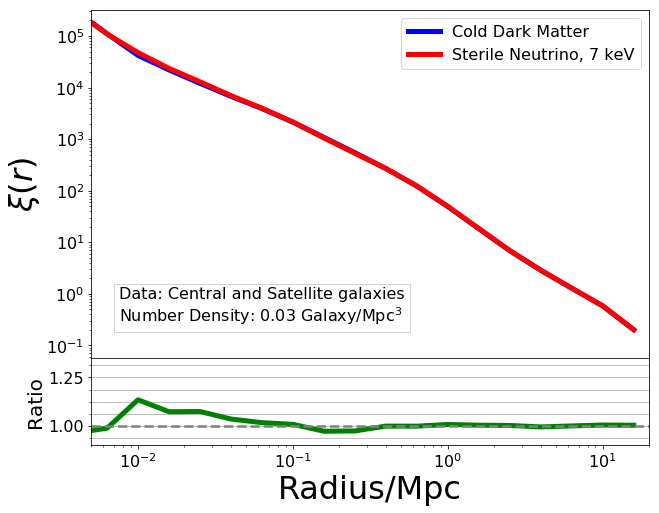

In [13]:
CUTE_cdm_sorted = np.genfromtxt("Output/corr_cdm_galaxy4.txt", usecols = (0,1))
CUTE_wdm_sorted = np.genfromtxt("Output/corr_wdm_galaxy4.txt", usecols = (0,1))

textstr = '\n'.join((
    r'Data: Central and Satellite galaxies',
    r'Number Density: 0.03 Galaxy/Mpc$^{3}$'))
props = dict(facecolor='none', edgecolor='lightgrey', pad = 5.0)

plt.figure(figsize=(10,8))
grid = gridspec.GridSpec(2,1, height_ratios = [4,1])
grid.update(hspace = 0)
grid0 = plt.subplot(grid[0])
grid1 = plt.subplot(grid[1])

grid0.loglog(CUTE_cdm_sorted[:,0], CUTE_cdm_sorted[:,1], label = "Cold Dark Matter", linewidth = 5, 
             color = "blue")
grid0.loglog(CUTE_wdm_sorted[:,0], CUTE_wdm_sorted[:,1], label = "Sterile Neutrino, 7 keV", linewidth = 5, 
             color = "red")
grid0.set_xlim(5*10**-3, 2e1)
grid0.set_ylim(10**-1.25, 10**5.5)
grid0.set_ylabel(r"$\xi(r)$", fontsize = 32)
grid0.legend(fontsize = 16)
grid0.minorticks_on()
grid0.tick_params(labelsize=16)
grid0.text(0.05, 0.2, textstr, transform=grid0.transAxes, fontsize=16, verticalalignment='top', bbox=props)

grid1.semilogx(CUTE_wdm_sorted[:,0], CUTE_wdm_sorted[:,1]/CUTE_cdm_sorted[:,1], linewidth = 5, color = "green")
grid1.set_xlabel("Radius/Mpc", fontsize = 32)
grid1.set_ylabel("Ratio", fontsize = 20)
grid1.axhline(y = 1, color = "grey", ls = "--", linewidth = 2.5)
grid1.set_xlim(5*10**-3, 2e1)
grid1.set_ylim(0.9, 1.35)
grid1.minorticks_on()
grid1.tick_params(labelsize=16)
grid1.yaxis.grid(which = "both")

plt.show()

In [14]:
# transfer to odyssey
file='galaxy4'
subsample(file,'jackknife_'+file)

C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in true_divide


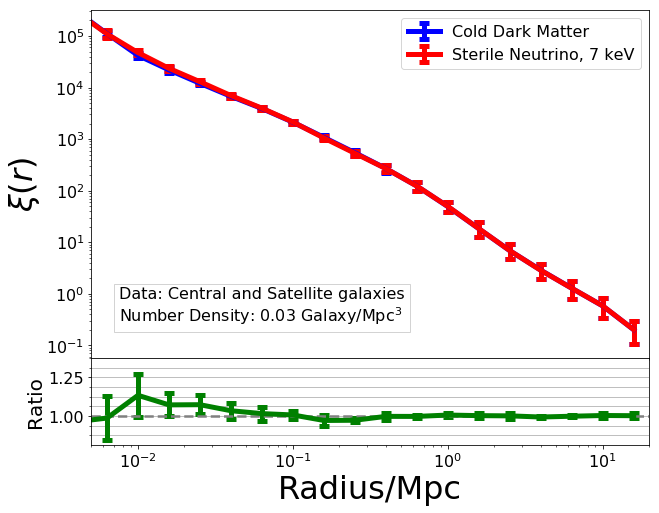

In [15]:
# plot the figure
file='galaxy4'
textstr = '\n'.join((
    r'Data: Central and Satellite galaxies',
    r'Number Density: 0.03 Galaxy/Mpc$^{3}$'))
plot(file,textstr,save=True)

### Figure B1

C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


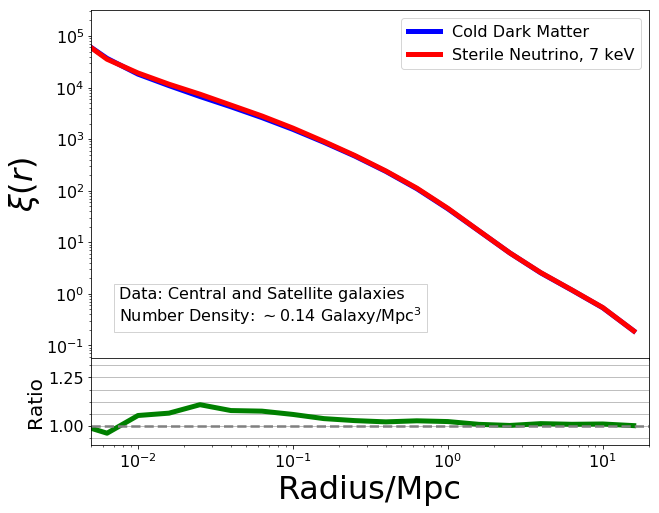

In [16]:
CUTE_cdm_sorted = np.genfromtxt("Output/corr_cdm_galaxy3.txt", usecols = (0,1))
CUTE_wdm_sorted = np.genfromtxt("Output/corr_wdm_galaxy3.txt", usecols = (0,1))

textstr = '\n'.join((
    r'Data: Central and Satellite galaxies',
    r'Number Density: $\sim$0.14 Galaxy/Mpc$^{3}$'))
props = dict(facecolor='none', edgecolor='lightgrey', pad = 5.0)

plt.figure(figsize=(10,8))
grid = gridspec.GridSpec(2,1, height_ratios = [4,1])
grid.update(hspace = 0)
grid0 = plt.subplot(grid[0])
grid1 = plt.subplot(grid[1])

grid0.loglog(CUTE_cdm_sorted[:,0], CUTE_cdm_sorted[:,1], label = "Cold Dark Matter", linewidth = 5, 
             color = "blue")
grid0.loglog(CUTE_wdm_sorted[:,0], CUTE_wdm_sorted[:,1], label = "Sterile Neutrino, 7 keV", linewidth = 5, 
             color = "red")
grid0.set_xlim(5*10**-3, 2e1)
grid0.set_ylim(10**-1.25, 10**5.5)
grid0.set_ylabel(r"$\xi(r)$", fontsize = 32)
grid0.legend(fontsize = 16)
grid0.minorticks_on()
grid0.tick_params(labelsize=16)
grid0.text(0.05, 0.2, textstr, transform=grid0.transAxes, fontsize=16, verticalalignment='top', bbox=props)

grid1.semilogx(CUTE_wdm_sorted[:,0], CUTE_wdm_sorted[:,1]/CUTE_cdm_sorted[:,1], linewidth = 5, color = "green")
grid1.set_xlabel("Radius/Mpc", fontsize = 32)
grid1.set_ylabel("Ratio", fontsize = 20)
grid1.axhline(y = 1, color = "grey", ls = "--", linewidth = 2.5)
grid1.set_xlim(5*10**-3, 2e1)
grid1.set_ylim(0.9, 1.35)
grid1.minorticks_on()
grid1.tick_params(labelsize=16)
grid1.yaxis.grid(which = "both")

plt.show()

In [17]:
# transfer to odyssey
file='galaxy3'
subsample(file,'jackknife_'+file)

C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in subtract
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in true_divide


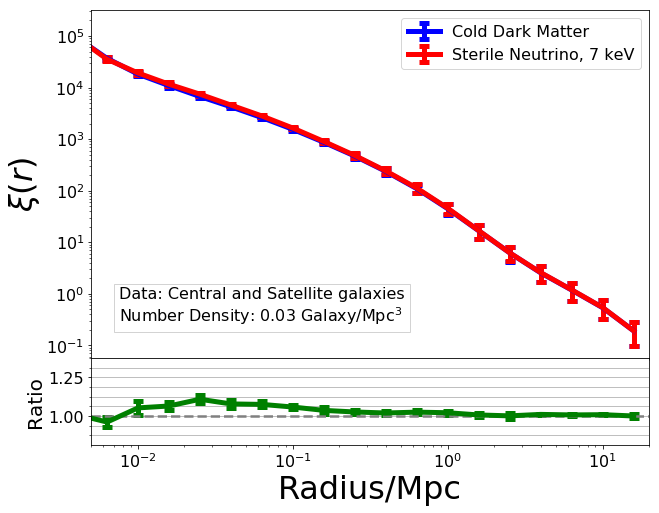

In [18]:
# plot the figure
file='galaxy3'
textstr = '\n'.join((
    r'Data: Central and Satellite galaxies', 
    r'Number Density: 0.03 Galaxy/Mpc$^{3}$'))
plot(file,textstr,save=True)

### Figure 8

C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


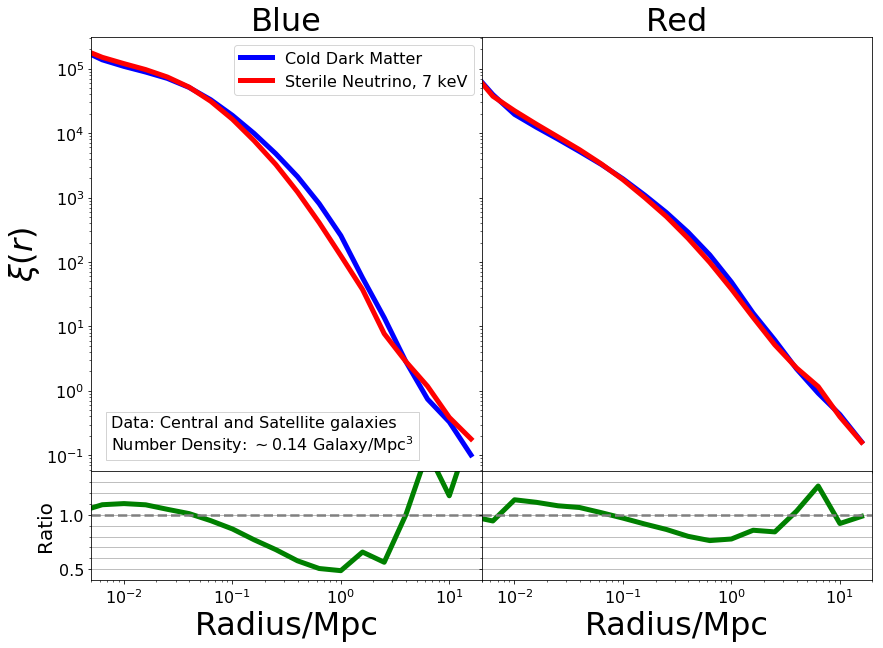

In [19]:
CUTE_cdm_blue = np.genfromtxt("Output/corr_cdm_color1.txt", usecols = (0,1))
CUTE_wdm_blue = np.genfromtxt("Output/corr_wdm_color1.txt", usecols = (0,1))

CUTE_cdm_red = np.genfromtxt("Output/corr_cdm_color2.txt", usecols = (0,1))
CUTE_wdm_red = np.genfromtxt("Output/corr_wdm_color2.txt", usecols = (0,1))

grid = gridspec.GridSpec(2,2, height_ratios = [4,1])
grid.update(hspace = 0, wspace = 0)
plt.figure(figsize=(14,10))
    
grid0 = plt.subplot(grid[0])
grid1 = plt.subplot(grid[1])
grid2 = plt.subplot(grid[2])
grid3 = plt.subplot(grid[3])

textstr = '\n'.join((
    r'Data: Central and Satellite galaxies',
    r'Number Density: $\sim$0.14 Galaxy/Mpc$^{3}$'))
props = dict(facecolor='none', edgecolor='lightgrey', pad = 5.0)

grid0.loglog(CUTE_cdm_blue[:,0], CUTE_cdm_blue[:,1], label = "Cold Dark Matter", linewidth = 5, color = "blue")
grid0.loglog(CUTE_wdm_blue[:,0], CUTE_wdm_blue[:,1], label = "Sterile Neutrino, 7 keV", linewidth = 5, 
             color = "red")
grid0.set_ylabel(r"$\xi(r)$", fontsize = 32)
grid0.set_title(r"Blue", fontsize = 32)
grid0.legend(fontsize = 16)
grid0.tick_params(labelsize=16)
grid0.text(0.05, 0.125, textstr, transform=grid0.transAxes, fontsize=16, verticalalignment='top', bbox=props)

grid1.loglog(CUTE_cdm_red[:,0], CUTE_cdm_red[:,1],  linewidth = 5, color = "blue")
grid1.loglog(CUTE_wdm_red[:,0], CUTE_wdm_red[:,1],  linewidth = 5, color = "red")
grid1.set_title(r"Red", fontsize = 32)

grid2.semilogx(CUTE_wdm_blue[:,0], CUTE_wdm_blue[:,1]/CUTE_cdm_blue[:,1], linewidth = 5, color = "green")
grid2.set_xlabel("Radius/Mpc", fontsize = 32)
grid2.set_ylabel("Ratio", fontsize = 20)
grid2.tick_params(labelsize=16)
grid2.yaxis.grid(which = "both")

grid3.semilogx(CUTE_wdm_red[:,0], CUTE_wdm_red[:,1]/CUTE_cdm_red[:,1], linewidth = 5, color = "green")
grid3.set_xlabel("Radius/Mpc", fontsize = 32)
grid3.tick_params(labelsize=16)
grid3.yaxis.grid(which = "both")

for i in range(4):
    plt.subplot(grid[i]).minorticks_on()
    plt.subplot(grid[i]).set_xlim(5*10**-3, 2e1)
    plt.subplot(grid[i]).set_ylim(10**-1.25, 10**5.5)

for i in range(2,4):
    plt.subplot(grid[i]).set_ylim(0.4, 1.4)
    plt.subplot(grid[i]).axhline(y = 1, color = "grey", ls = "--", linewidth = 2.5)
    
for i in [1,3]:
    plt.subplot(grid[i]).set_yticklabels([]) 
    
plt.show()

In [20]:
# transfer the blue data to odyssey
file1='color1'
subsample(file1,'jackknife_'+file1)

# transfer the red data to odyssey
file2='color2'
subsample(file2,'jackknife_'+file2)

### Define another function to plot the correlation function with the jackknife error bars!

In [21]:
def plot_two(file,title,textstr,xlim=[5*10**-3,2e1],ylim=[10**-2,10**5.5],ylim_ratio=[0.4,1.4],save=False):

    file1, file2 = file
    title1, title2 = title
    
    CUTE_cdm_file1 = np.genfromtxt("Output/corr_cdm_"+file1+".txt", usecols = (0,1))
    CUTE_wdm_file1 = np.genfromtxt("Output/corr_wdm_"+file1+".txt", usecols = (0,1))
    
    CUTE_cdm_file2 = np.genfromtxt("Output/corr_cdm_"+file2+".txt", usecols = (0,1))
    CUTE_wdm_file2 = np.genfromtxt("Output/corr_wdm_"+file2+".txt", usecols = (0,1))
    
    cdm_jackknife_file1,wdm_jackknife_file1,ratio_jackknife_file1=jackknife('jackknife_'+file1)
    cdm_jackknife_file2,wdm_jackknife_file2,ratio_jackknife_file2=jackknife('jackknife_'+file2)

    props = dict(facecolor='none', edgecolor='lightgrey', pad = 5.0)
    grid = gridspec.GridSpec(2,2, height_ratios = [4,1])
    grid.update(hspace = 0, wspace = 0)
    plt.figure(figsize=(14,10))

    grid0 = plt.subplot(grid[0])
    grid1 = plt.subplot(grid[1])
    grid2 = plt.subplot(grid[2])
    grid3 = plt.subplot(grid[3])

    grid0.errorbar(CUTE_cdm_file1[:,0], CUTE_cdm_file1[:,1], yerr = cdm_jackknife_file1, capsize = 5, 
                   capthick = 5, label = "Cold Dark Matter", linewidth = 5, color = "blue")
    grid0.errorbar(CUTE_wdm_file1[:,0], CUTE_wdm_file1[:,1], yerr = wdm_jackknife_file1, capsize = 5, 
                   capthick = 5, label = "Sterile Neutrino, 7 keV", linewidth = 5, color = "red")
    grid0.text(0.05, 0.125, textstr, transform=grid0.transAxes, fontsize=16, verticalalignment='top', 
               bbox=props)
    grid0.set_ylabel(r"$\xi(r)$", fontsize = 32)
    grid0.set_title(title1, fontsize = 32) 
    grid0.legend(fontsize = 16)

    grid1.errorbar(CUTE_cdm_file2[:,0], CUTE_cdm_file2[:,1], yerr = cdm_jackknife_file2, capsize = 5, 
                   capthick = 5, linewidth = 5, color = "blue")
    grid1.errorbar(CUTE_wdm_file2[:,0], CUTE_wdm_file2[:,1], yerr = wdm_jackknife_file2, capsize = 5, 
                   capthick = 5, linewidth = 5, color = "red")
    grid1.set_title(title2, fontsize = 32)

    grid2.errorbar(CUTE_wdm_file1[:,0], CUTE_wdm_file1[:,1]/CUTE_cdm_file1[:,1], yerr = ratio_jackknife_file1, 
                   capsize = 5, capthick = 5, linewidth = 5, color = "green")
    grid2.set_xlabel("Radius/Mpc", fontsize = 32)
    grid2.set_ylabel("Ratio", fontsize = 20)

    grid3.errorbar(CUTE_wdm_file2[:,0], CUTE_wdm_file2[:,1]/CUTE_cdm_file2[:,1], yerr = ratio_jackknife_file2, 
                   capsize = 5, capthick = 5, linewidth = 5, color = "green")
    grid3.set_xlabel("Radius/Mpc", fontsize = 32)

    for i in range(4):
        plt.subplot(grid[i]).set_xlim(xlim[0],xlim[1])
        plt.subplot(grid[i]).tick_params(labelsize=16)
        plt.subplot(grid[i]).set_xscale("Log")
        plt.subplot(grid[i]).minorticks_on()
    
    for i in range(2):
        plt.subplot(grid[i]).set_ylim(ylim[0],ylim[1]) #10**-1.25,10**5.5
        plt.subplot(grid[i]).set_yscale("Log") 

    for i in range(2,4):
        plt.subplot(grid[i]).set_ylim(ylim_ratio[0],ylim_ratio[1]) #0.4, 2
        plt.subplot(grid[i]).axhline(y = 1, color = "grey", ls = "--", linewidth = 2.5)
        plt.subplot(grid[i]).yaxis.grid(which = "both")

    for i in [1,3]:
        plt.subplot(grid[i]).set_yticklabels([]) 

    if save==True:
        plt.savefig('Images/Summer2020/'+file1+'_'+file2+'.pdf')
    plt.show()

C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in 

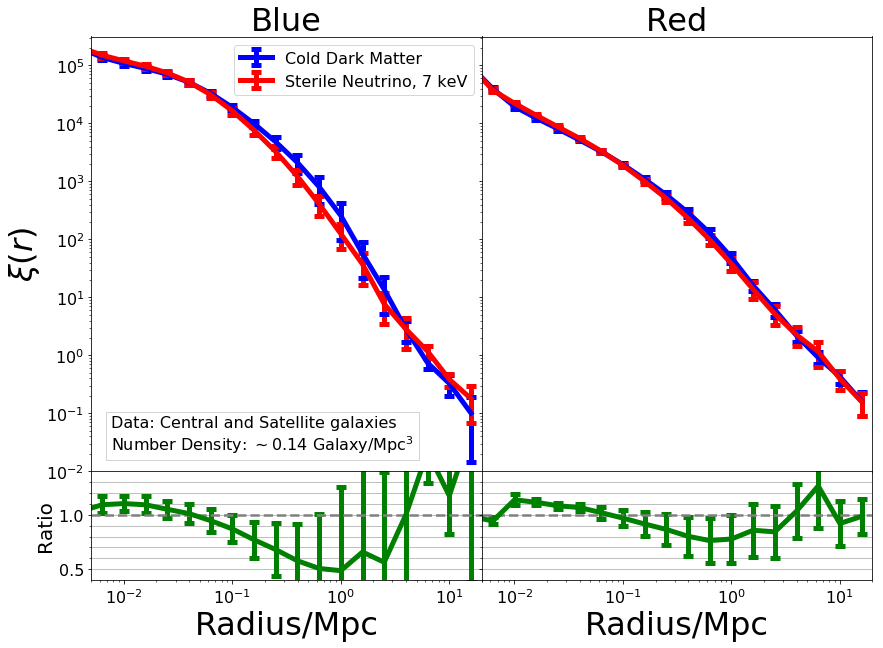

In [22]:
# plot the figure
file='color1','color2'
title='Blue','Red'
textstr = '\n'.join((
    r'Data: Central and Satellite galaxies',
    r'Number Density: $\sim0.14$ Galaxy/Mpc$^{3}$'))
plot_two(file,title,textstr,save=True)

### Figure 9

C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


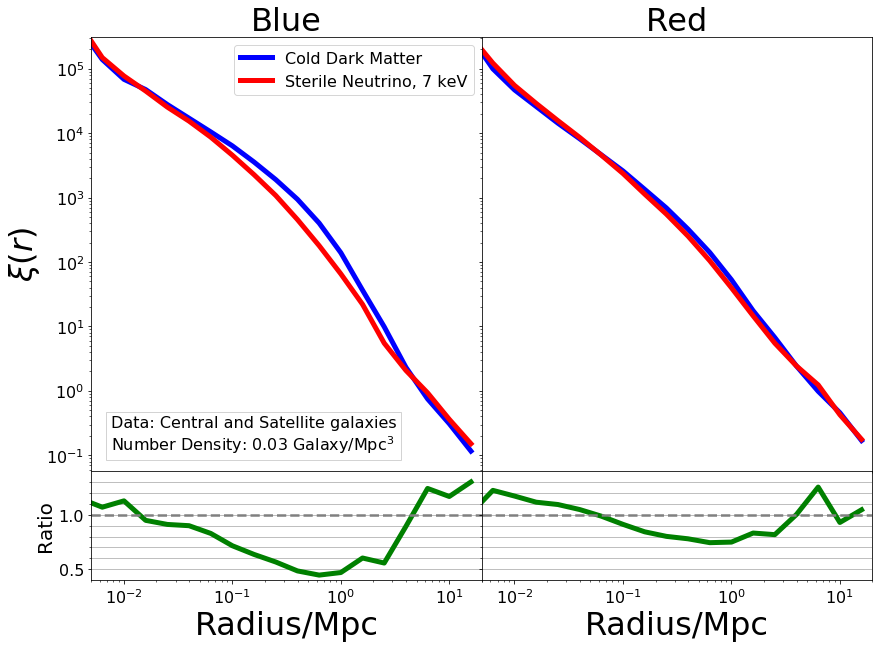

In [23]:
CUTE_cdm_blue = np.genfromtxt("Output/corr_cdm_color1_sample.txt", usecols = (0,1))
CUTE_wdm_blue = np.genfromtxt("Output/corr_wdm_color1_sample.txt", usecols = (0,1))

CUTE_cdm_red = np.genfromtxt("Output/corr_cdm_color2_sample.txt", usecols = (0,1))
CUTE_wdm_red = np.genfromtxt("Output/corr_wdm_color2_sample.txt", usecols = (0,1))

grid = gridspec.GridSpec(2,2, height_ratios = [4,1])
grid.update(hspace = 0, wspace = 0)
plt.figure(figsize=(14,10))
    
grid0 = plt.subplot(grid[0])
grid1 = plt.subplot(grid[1])
grid2 = plt.subplot(grid[2])
grid3 = plt.subplot(grid[3])

textstr = '\n'.join((
    r'Data: Central and Satellite galaxies',
    r'Number Density: 0.03 Galaxy/Mpc$^{3}$'))
props = dict(facecolor='none', edgecolor='lightgrey', pad = 5.0)

grid0.loglog(CUTE_cdm_blue[:,0], CUTE_cdm_blue[:,1], label = "Cold Dark Matter", linewidth = 5, color = "blue")
grid0.loglog(CUTE_wdm_blue[:,0], CUTE_wdm_blue[:,1], label = "Sterile Neutrino, 7 keV", linewidth = 5, 
             color = "red")
grid0.set_ylabel(r"$\xi(r)$", fontsize = 32)
grid0.set_title(r"Blue", fontsize = 32)
grid0.legend(fontsize = 16)
grid0.tick_params(labelsize=16)
grid0.text(0.05, 0.125, textstr, transform=grid0.transAxes, fontsize=16, verticalalignment='top', bbox=props)

grid1.loglog(CUTE_cdm_red[:,0], CUTE_cdm_red[:,1],  linewidth = 5, color = "blue")
grid1.loglog(CUTE_wdm_red[:,0], CUTE_wdm_red[:,1],  linewidth = 5, color = "red")
grid1.set_title(r"Red", fontsize = 32)
grid1.set_xticks([])
grid1.set_xticklabels([])
grid1.tick_params(labelsize=16)

grid2.semilogx(CUTE_wdm_blue[:,0], CUTE_wdm_blue[:,1]/CUTE_cdm_blue[:,1], linewidth = 5, color = "green")
grid2.set_xlabel("Radius/Mpc", fontsize = 32)
grid2.set_ylabel("Ratio", fontsize = 20)
grid2.tick_params(labelsize=16)
grid2.yaxis.grid(which = "both")

grid3.semilogx(CUTE_wdm_red[:,0], CUTE_wdm_red[:,1]/CUTE_cdm_red[:,1], linewidth = 5, color = "green")
grid3.set_xlabel("Radius/Mpc", fontsize = 32)
grid3.tick_params(labelsize=16)
grid3.yaxis.grid(which = "both")

for i in range(4):
    plt.subplot(grid[i]).minorticks_on()
    plt.subplot(grid[i]).set_xlim(5*10**-3, 2e1)
    plt.subplot(grid[i]).set_ylim(10**-1.25, 10**5.5)

for i in range(2,4):
    plt.subplot(grid[i]).set_ylim(0.4, 1.4)
    plt.subplot(grid[i]).axhline(y = 1, color = "grey", ls = "--", linewidth = 2.5)
    
for i in [1,3]:
    plt.subplot(grid[i]).set_yticklabels([]) 
    
plt.show()

In [24]:
# transfer the blue data to odyssey
file1='color1_sample'
subsample(file1,'jackknife_'+file1)

# transfer the red data to odyssey
file2='color2_sample'
subsample(file2,'jackknife_'+file2)

C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


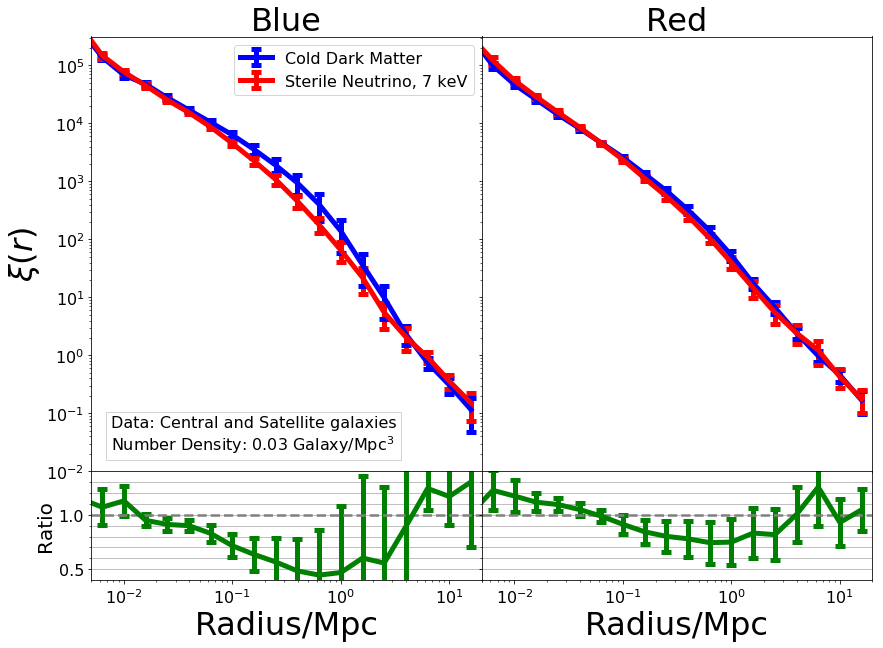

In [25]:
# plot the figure
file='color1_sample','color2_sample'
title='Blue','Red'
textstr = '\n'.join((
    r'Data: Central and Satellite galaxies',
    r'Number Density: 0.03 Galaxy/Mpc$^{3}$'))
plot_two(file,title,textstr,save=True)

### Figure 12

C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


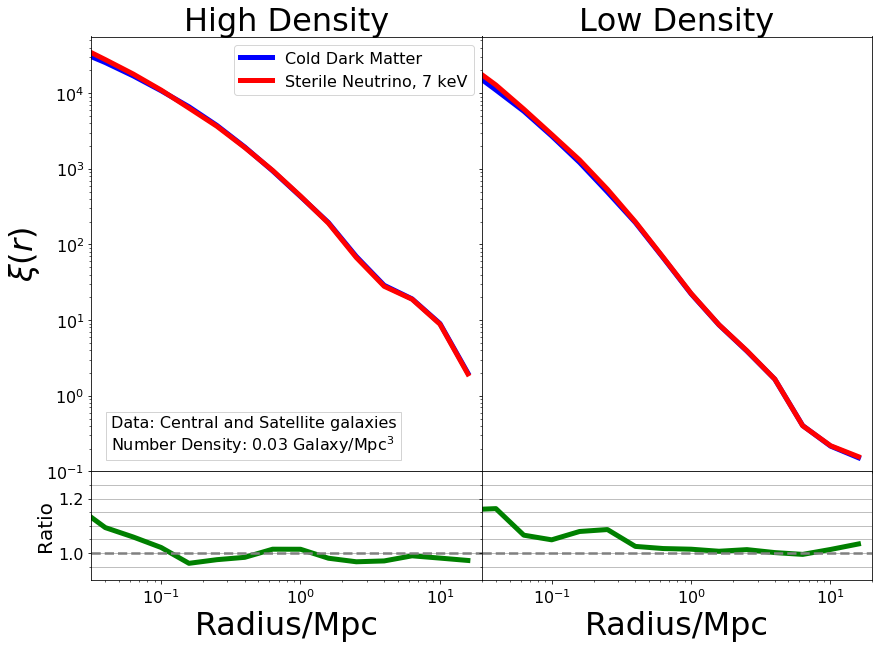

In [26]:
CUTE_cdm_high = np.genfromtxt("Output/corr_cdm_top_galaxy_position_filtered.txt", usecols = (0,1))
CUTE_cdm_low = np.genfromtxt("Output/corr_cdm_low_galaxy_position_filtered.txt", usecols = (0,1))
CUTE_wdm_high = np.genfromtxt("Output/corr_wdm_top_galaxy_position_filtered.txt", usecols = (0,1))
CUTE_wdm_low = np.genfromtxt("Output/corr_wdm_low_galaxy_position_filtered.txt", usecols = (0,1))

textstr = '\n'.join((
    r'Data: Central and Satellite galaxies',
    r'Number Density: 0.03 Galaxy/Mpc$^{3}$'))
props = dict(facecolor='none', edgecolor='lightgrey', pad = 5.0)

plt.figure(figsize=(14,10))
grid = gridspec.GridSpec(2,2, height_ratios = [4,1])
grid.update(hspace = 0, wspace = 0)
grid0 = plt.subplot(grid[0])
grid1 = plt.subplot(grid[1])
grid2 = plt.subplot(grid[2])
grid3 = plt.subplot(grid[3])

#High density
grid0.loglog(CUTE_cdm_high[:,0], CUTE_cdm_high[:,1], label = "Cold Dark Matter", linewidth = 5, color = "blue")
grid0.loglog(CUTE_wdm_high[:,0], CUTE_wdm_high[:,1], label = "Sterile Neutrino, 7 keV", linewidth = 5, 
             color = "red")
grid0.text(0.05, 0.125, textstr, transform=grid0.transAxes, fontsize=16, verticalalignment='top', bbox=props)
grid0.set_ylabel(r"$\xi(r)$", fontsize = 32)
grid0.set_title('High Density',fontsize=32)
grid0.legend(fontsize = 16)

grid2.semilogx(CUTE_wdm_high[:,0], CUTE_wdm_high[:,1]/CUTE_cdm_high[:,1], linewidth = 5, color = "green")
grid2.set_xlabel("Radius/Mpc", fontsize = 32)
grid2.set_ylabel("Ratio", fontsize=20)
grid2.axhline(y = 1, color = "grey", ls = "--", linewidth = 2.5)

#Low density
grid1.loglog(CUTE_cdm_low[:,0], CUTE_cdm_low[:,1], label = "Cold Dark Matter", linewidth = 5, color = "blue")
grid1.loglog(CUTE_wdm_low[:,0], CUTE_wdm_low[:,1], label = "Sterile Neutrino, 7 keV", linewidth = 5, 
             color = "red")
grid1.set_title('Low Density',fontsize=32)

grid3.semilogx(CUTE_wdm_low[:,0], CUTE_wdm_low[:,1]/CUTE_cdm_low[:,1], linewidth = 5, color = "green")
grid3.set_xlabel("Radius/Mpc", fontsize = 32)
grid3.axhline(y = 1, color = "grey", ls = "--", linewidth = 2.5)

for i in range(4):
    plt.subplot(grid[i]).set_xlim(10**-1.5, 2e1)
    plt.subplot(grid[i]).minorticks_on()
    plt.subplot(grid[i]).tick_params(labelsize=16)
    
for i in [0,1]:
    plt.subplot(grid[i]).set_ylim(10**-1, 10**4.75)
    
for i in [2,3]:
    plt.subplot(grid[i]).set_ylim(0.9, 1.3)
    plt.subplot(grid[i]).yaxis.grid(which = "both")
    
for i in [1,3]:
    plt.subplot(grid[i]).set_yticklabels([])

plt.show()

In [27]:
# transfer the high density data to odyssey
file1='top_galaxy_position_filtered'
subsample(file1,'jackknife_'+file1,'Calculations')

# transfer the low density data to odyssey
file2='low_galaxy_position_filtered'
subsample(file2,'jackknife_'+file2,'Calculations')

C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


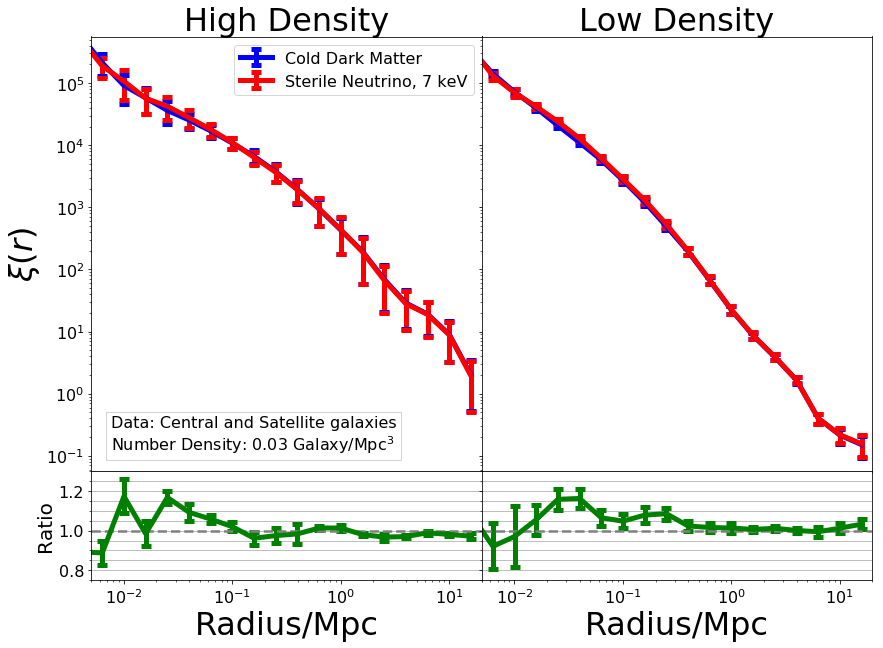

In [28]:
# plot the figure
file='top_galaxy_position_filtered','low_galaxy_position_filtered'
title='High Density','Low Density'
textstr = '\n'.join((
    r'Data: Central and Satellite galaxies',
    r'Number Density: 0.03 Galaxy/Mpc$^{3}$'))
plot_two(file,title,textstr,ylim=[10**-1.25,10**5.75],ylim_ratio=[0.75,1.3],save=True)

### Figure 13

C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide


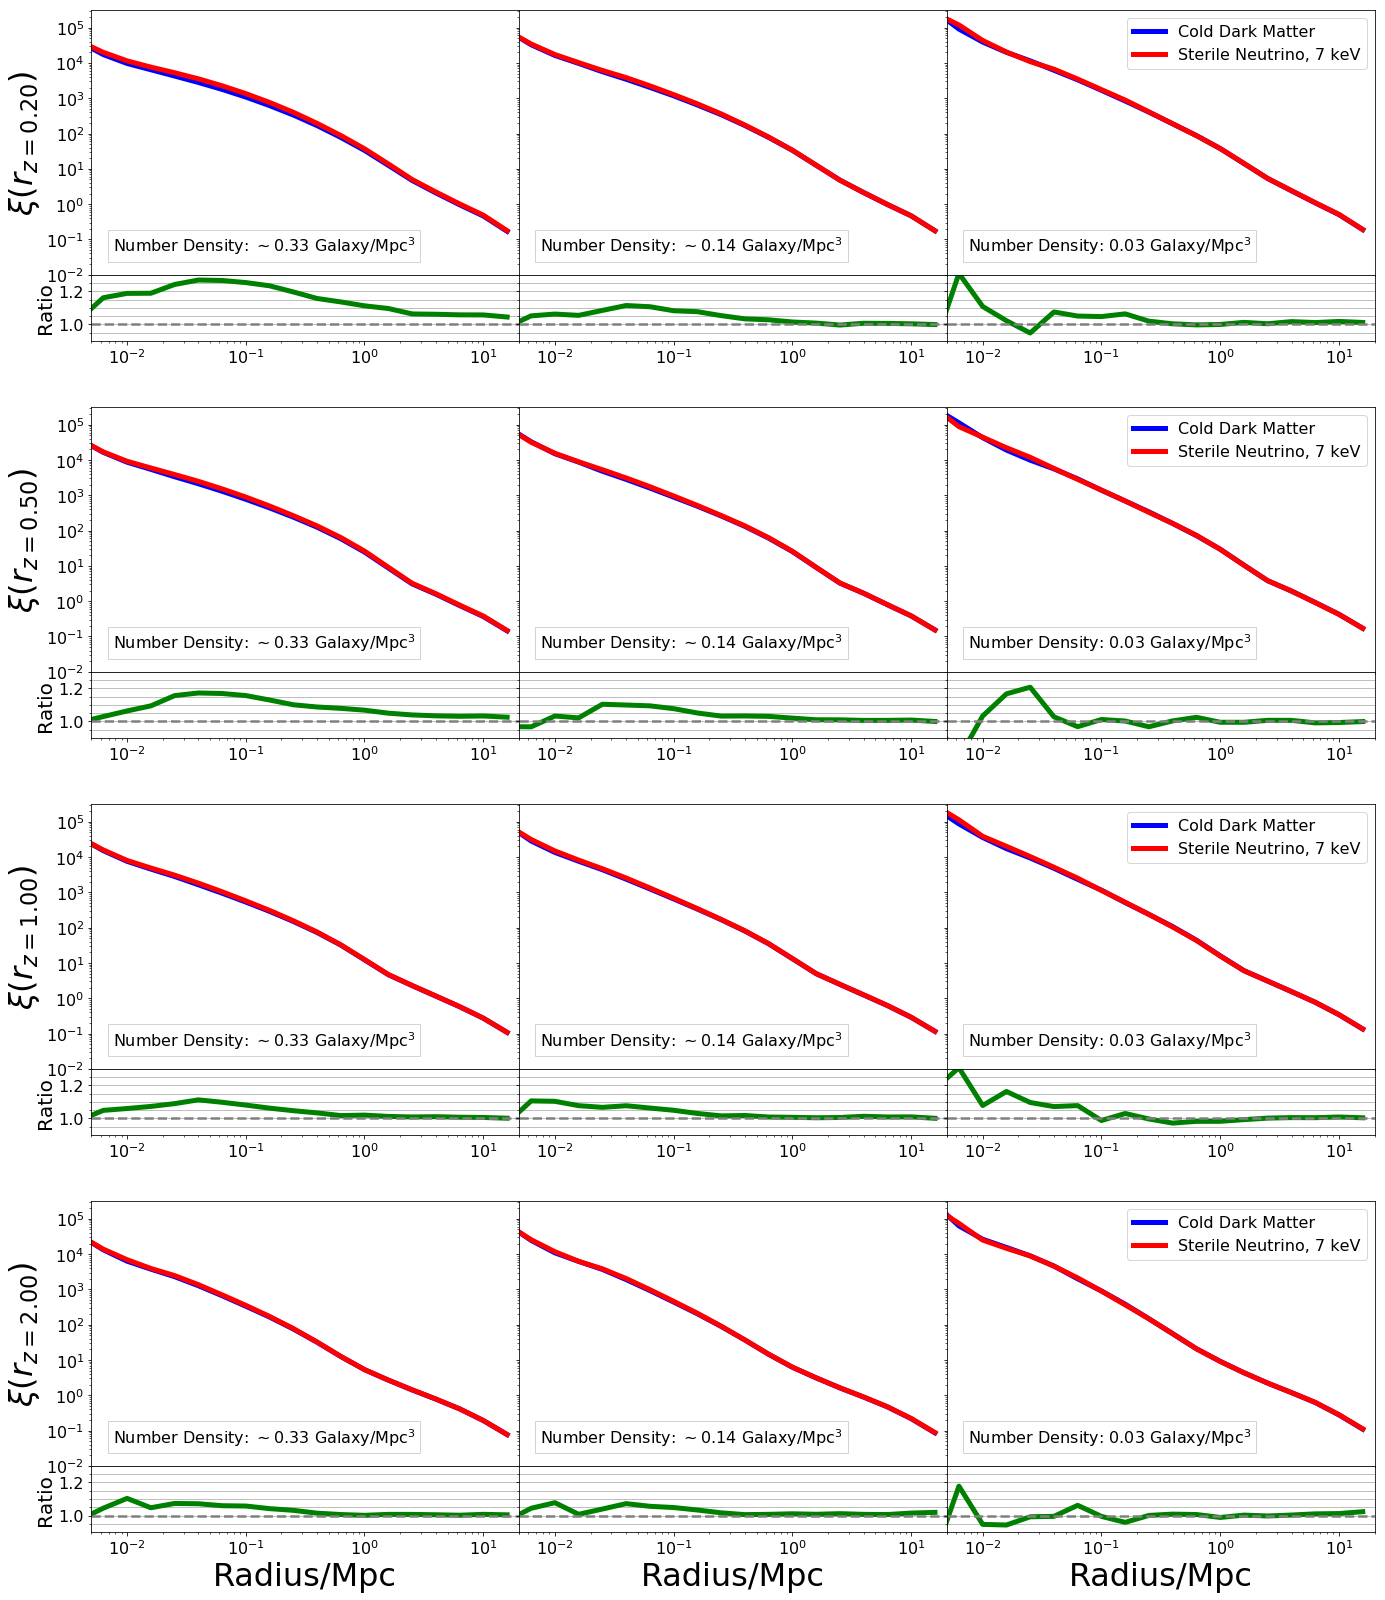

In [29]:
fig = plt.figure(figsize = (23,28)) # 30,32 #21,30 #23,28
gs = gridspec.GridSpec(4, 1)

i=0
for z in [0.2,0.5,1.00,2.00]:
    
    z="{:.2f}".format(z)
        
    # load data
    CUTE_cdm_n1 = np.genfromtxt("Output/redshift/corr_cdm_galaxy_position_z"+z+"_n0.33.txt")
    CUTE_wdm_n1 = np.genfromtxt("Output/redshift/corr_wdm_galaxy_position_z"+z+"_n0.33.txt")

    CUTE_cdm_n2 = np.genfromtxt("Output/redshift/corr_cdm_galaxy_position_z"+z+"_n0.14.txt")
    CUTE_wdm_n2 = np.genfromtxt("Output/redshift/corr_wdm_galaxy_position_z"+z+"_n0.14.txt")

    CUTE_cdm_n3 = np.genfromtxt("Output/redshift/corr_cdm_galaxy_position_z"+z+"_n0.03.txt")
    CUTE_wdm_n3 = np.genfromtxt("Output/redshift/corr_wdm_galaxy_position_z"+z+"_n0.03.txt")

    grid = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec = gs[i], hspace = 0, wspace = 0, 
                                            height_ratios=[4,1])

    # first grid
    grid0 = fig.add_subplot(grid[0])
    grid0.loglog(CUTE_cdm_n1[:,0], CUTE_cdm_n1[:,1], linewidth = 5, color = "blue")
    grid0.loglog(CUTE_wdm_n1[:,0], CUTE_wdm_n1[:,1], linewidth = 5, color = "red")
    grid0.set_ylabel(r"$\xi(r_{z="+z+"})$", fontsize = 32)

    # second grid
    grid1 = fig.add_subplot(grid[1])
    grid1.loglog(CUTE_cdm_n2[:,0], CUTE_cdm_n2[:,1], linewidth = 5, color = "blue")
    grid1.loglog(CUTE_wdm_n2[:,0], CUTE_wdm_n2[:,1], linewidth = 5, color = "red")

    # third grid
    grid2 = fig.add_subplot(grid[2])
    grid2.loglog(CUTE_cdm_n3[:,0], CUTE_cdm_n3[:,1], label = "Cold Dark Matter", linewidth = 5, color = "blue")
    grid2.loglog(CUTE_wdm_n3[:,0], CUTE_wdm_n3[:,1], label = "Sterile Neutrino, 7 keV", linewidth = 5, 
                 color = "red")
    grid2.legend(fontsize = 16)
    
    # fourth grid
    grid3 = fig.add_subplot(grid[3], sharex=grid0)
    grid3.semilogx(CUTE_cdm_n1[:,0], CUTE_wdm_n1[:,1]/CUTE_cdm_n1[:,1], linewidth = 5, color = "green")
    grid3.set_ylabel("Ratio", fontsize = 20)

    # fifth grid
    grid4 = fig.add_subplot(grid[4])
    grid4.semilogx(CUTE_cdm_n2[:,0], CUTE_wdm_n2[:,1]/CUTE_cdm_n2[:,1], linewidth = 5, color = "green")
    
    # sixth grid
    grid5 = fig.add_subplot(grid[5])
    grid5.semilogx(CUTE_cdm_n3[:,0], CUTE_wdm_n3[:,1]/CUTE_cdm_n3[:,1], linewidth = 5, color = "green")

    # details
    for n,grid,offset in zip(['$\sim$0.33','$\sim$0.14','0.03'],[grid0,grid1,grid2],[0,1,2]):
        textstr = r'Number Density: '+n+' Galaxy/Mpc$^{3}$'
        props = dict(facecolor='none', edgecolor='lightgrey', pad = 5.0)
        grid.text(0.05+offset, 0.15, textstr, transform = grid0.transAxes, fontsize = 16, 
                   verticalalignment = 'top', bbox=props)
        grid.set_ylim(10**-2, 10**5.5)  
            
    for grid in [grid3,grid4,grid5]:
        grid.axhline(y = 1, color = "grey", ls = "--", linewidth = 2.5)
        grid.set_ylim(0.9, 1.3)
        grid.yaxis.grid(which = "both")
        
        if i==3:
            grid.set_xlabel("Radius/Mpc", fontsize = 32)

    for grid in [grid1,grid2,grid4,grid5]:
        grid.set_yticklabels([])
        
    for grid in [grid0,grid1,grid2,grid3,grid4,grid5]:
        grid.tick_params(labelsize=16)
        grid.set_xlim(5*10**-3, 2e1)
        grid.minorticks_on()   
        
    i+=1
     
plt.show()

In [30]:
# loop through each redshift
for z in [0.2,0.5,1.00,2.00]:
    
    # and number density
    for n in [0.33,0.14,0.03]:
        
        # transfer the data to odyssey
        file="galaxy_position_z{:.2f}".format(z)+"_n{:.2f}".format(n)
        subsample(file,'jackknife_'+file,'Input\\redshift')

C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in subtract
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_

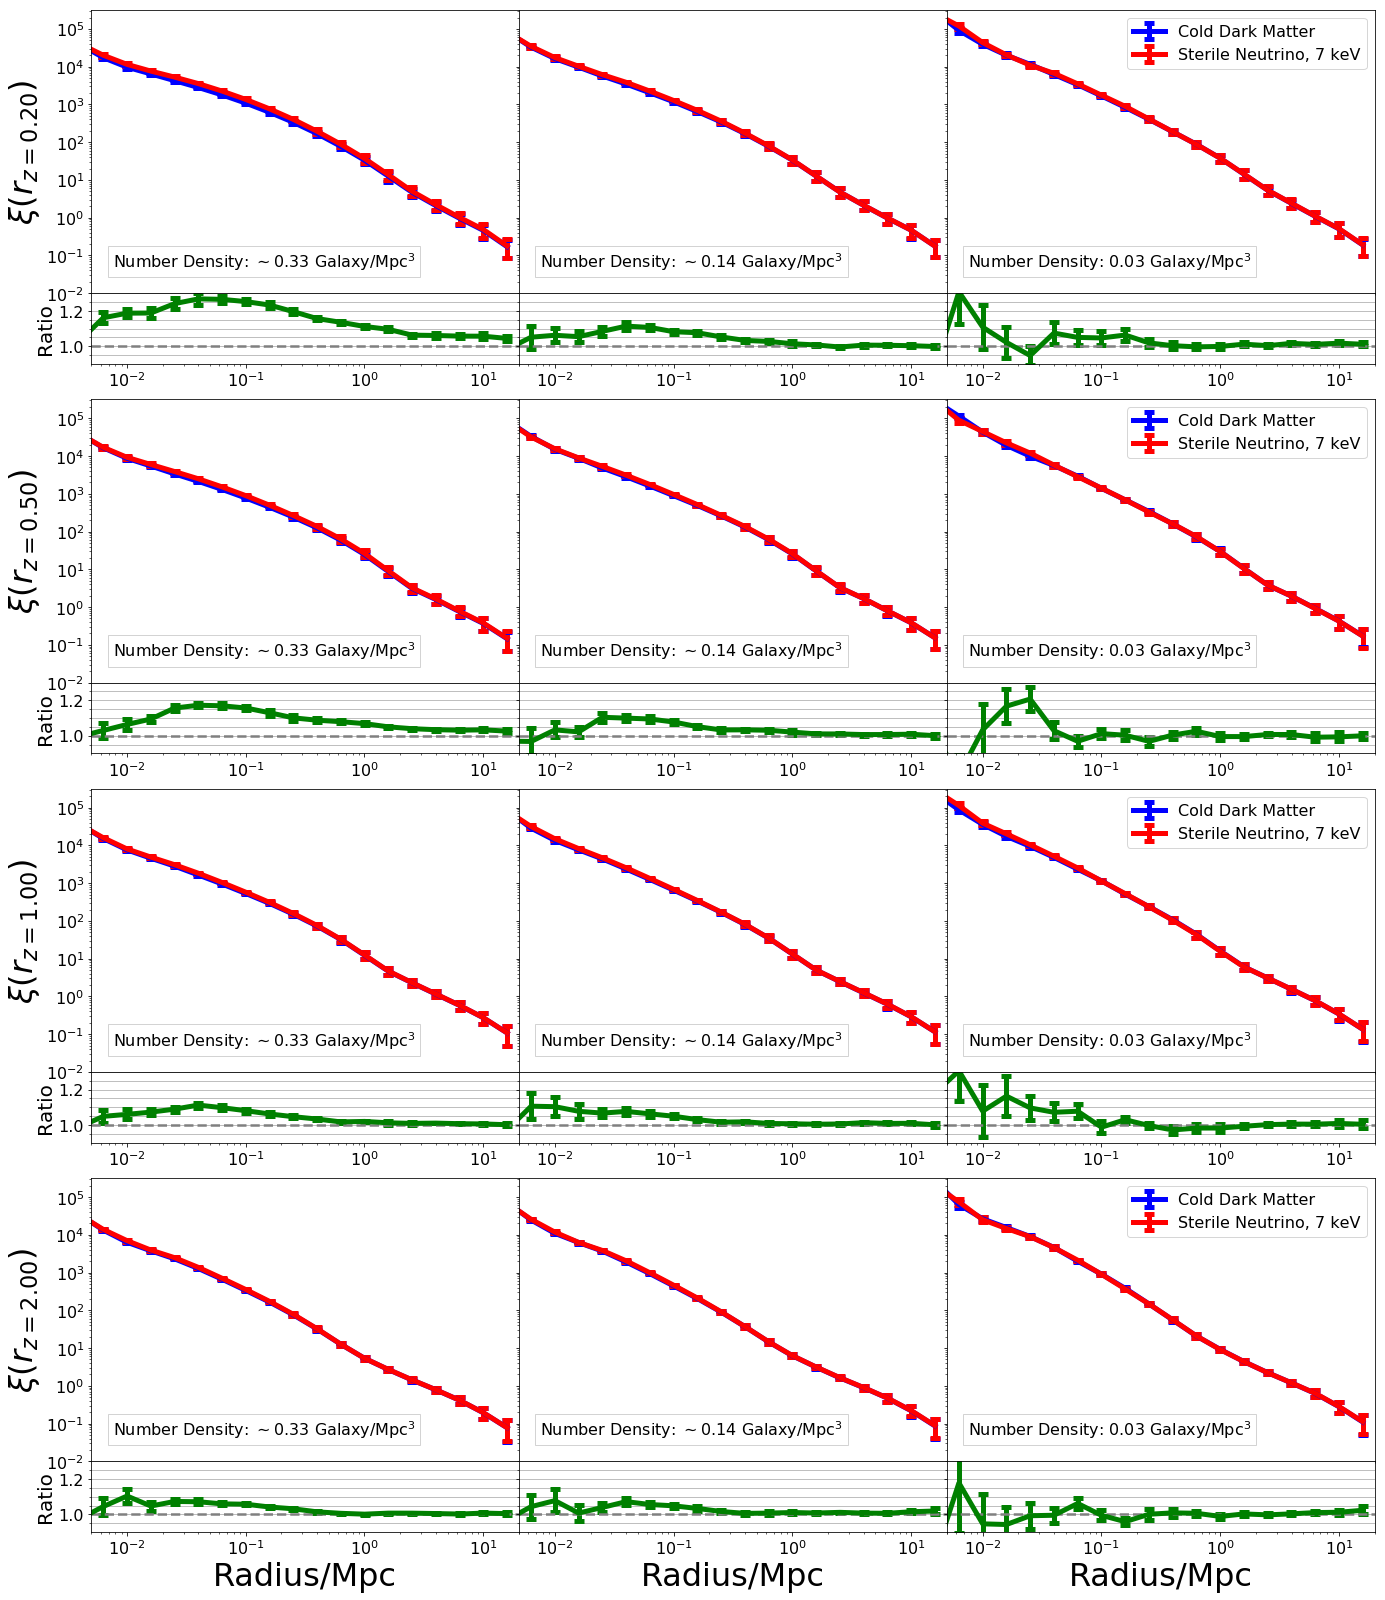

In [31]:
fig = plt.figure(figsize = (23,28)) # 30,32 #21,30 #23,28
gs = gridspec.GridSpec(4, 1)

i=0
for z in [0.2,0.5,1.00,2.00]:
    
    z="{:.2f}".format(z)
        
    # load data
    CUTE_cdm_n1 = np.genfromtxt("Output/redshift/corr_cdm_galaxy_position_z"+z+"_n0.33.txt")
    CUTE_wdm_n1 = np.genfromtxt("Output/redshift/corr_wdm_galaxy_position_z"+z+"_n0.33.txt")

    CUTE_cdm_n2 = np.genfromtxt("Output/redshift/corr_cdm_galaxy_position_z"+z+"_n0.14.txt")
    CUTE_wdm_n2 = np.genfromtxt("Output/redshift/corr_wdm_galaxy_position_z"+z+"_n0.14.txt")

    CUTE_cdm_n3 = np.genfromtxt("Output/redshift/corr_cdm_galaxy_position_z"+z+"_n0.03.txt")
    CUTE_wdm_n3 = np.genfromtxt("Output/redshift/corr_wdm_galaxy_position_z"+z+"_n0.03.txt")
    
    # transfer the error from odyssey
    file='galaxy_position_z'+z
    cdm_jackknife_n1,wdm_jackknife_n1,ratio_jackknife_n1=jackknife('jackknife_'+file+'_n0.33')
    cdm_jackknife_n2,wdm_jackknife_n2,ratio_jackknife_n2=jackknife('jackknife_'+file+'_n0.14')
    cdm_jackknife_n3,wdm_jackknife_n3,ratio_jackknife_n3=jackknife('jackknife_'+file+'_n0.03')

    # set up the grid
    grid = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec = gs[i], hspace = 0, wspace = 0, 
                                            height_ratios=[4,1])

    # first grid
    grid0 = fig.add_subplot(grid[0])
    grid0.errorbar(CUTE_cdm_n1[:,0], CUTE_cdm_n1[:,1], yerr = cdm_jackknife_n1, capsize = 5, 
                   capthick = 5, linewidth = 5, color = "blue")
    grid0.errorbar(CUTE_wdm_n1[:,0], CUTE_wdm_n1[:,1], yerr = wdm_jackknife_n1, capsize = 5, 
                   capthick = 5, linewidth = 5, color = "red")
    grid0.set_ylabel(r"$\xi(r_{z="+z+"})$", fontsize = 32)

    # second grid
    grid1 = fig.add_subplot(grid[1])
    grid1.errorbar(CUTE_cdm_n2[:,0], CUTE_cdm_n2[:,1], yerr = cdm_jackknife_n2, capsize = 5, 
                   capthick = 5, linewidth = 5, color = "blue")
    grid1.errorbar(CUTE_wdm_n2[:,0], CUTE_wdm_n2[:,1], yerr = wdm_jackknife_n2, capsize = 5, 
                   capthick = 5, linewidth = 5, color = "red")

    # third grid
    grid2 = fig.add_subplot(grid[2])
    grid2.errorbar(CUTE_cdm_n3[:,0], CUTE_cdm_n3[:,1], yerr = cdm_jackknife_n3, capsize = 5, 
                   capthick = 5, label = "Cold Dark Matter", linewidth = 5, color = "blue")
    grid2.errorbar(CUTE_wdm_n3[:,0], CUTE_wdm_n3[:,1], yerr = wdm_jackknife_n3, capsize = 5, 
                   capthick = 5, label = "Sterile Neutrino, 7 keV", linewidth = 5, color = "red")
    grid2.legend(fontsize = 16)
    
    # fourth grid
    grid3 = fig.add_subplot(grid[3], sharex=grid0)
    grid3.errorbar(CUTE_cdm_n1[:,0], CUTE_wdm_n1[:,1]/CUTE_cdm_n1[:,1], yerr = ratio_jackknife_n1, capsize = 5, 
                   capthick = 5, linewidth = 5, color = "green")
    grid3.set_ylabel("Ratio", fontsize = 20)

    # fifth grid
    grid4 = fig.add_subplot(grid[4])
    grid4.errorbar(CUTE_cdm_n2[:,0], CUTE_wdm_n2[:,1]/CUTE_cdm_n2[:,1], yerr = ratio_jackknife_n2, 
                   capsize = 5, capthick = 5, linewidth = 5, color = "green")
    
    # sixth grid
    grid5 = fig.add_subplot(grid[5])
    grid5.errorbar(CUTE_cdm_n3[:,0], CUTE_wdm_n3[:,1]/CUTE_cdm_n3[:,1], yerr = ratio_jackknife_n3, 
                   capsize = 5, capthick = 5, linewidth = 5, color = "green")

    # details
    for n,grid,offset in zip(['$\sim$0.33','$\sim$0.14','0.03'],[grid0,grid1,grid2],[0,1,2]):
        textstr = r'Number Density: '+n+' Galaxy/Mpc$^{3}$'
        props = dict(facecolor='none', edgecolor='lightgrey', pad = 5.0)
        grid.text(0.05+offset, 0.15, textstr, transform = grid0.transAxes, fontsize = 16, 
                   verticalalignment = 'top', bbox=props)
        grid.set_ylim(10**-2, 10**5.5)  
        grid.set_yscale("Log")
            
    for grid in [grid3,grid4,grid5]:
        grid.axhline(y = 1, color = "grey", ls = "--", linewidth = 2.5)
        grid.set_ylim(0.9, 1.3)
        grid.yaxis.grid(which = "both")
        
        if i==3:
            grid.set_xlabel("Radius/Mpc", fontsize = 32)

    for grid in [grid1,grid2,grid4,grid5]:
        grid.set_yticklabels([])
        
    for grid in [grid0,grid1,grid2,grid3,grid4,grid5]:
        grid.tick_params(labelsize=16)
        grid.set_xlim(5*10**-3, 2e1)
        grid.set_xscale("Log")
        grid.minorticks_on()   
        
    i+=1
     
gs.update(hspace = 0.1)
plt.savefig('Images/Summer2020/Redshift_Jackknife.pdf')
plt.show()

### Figure 14

C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide


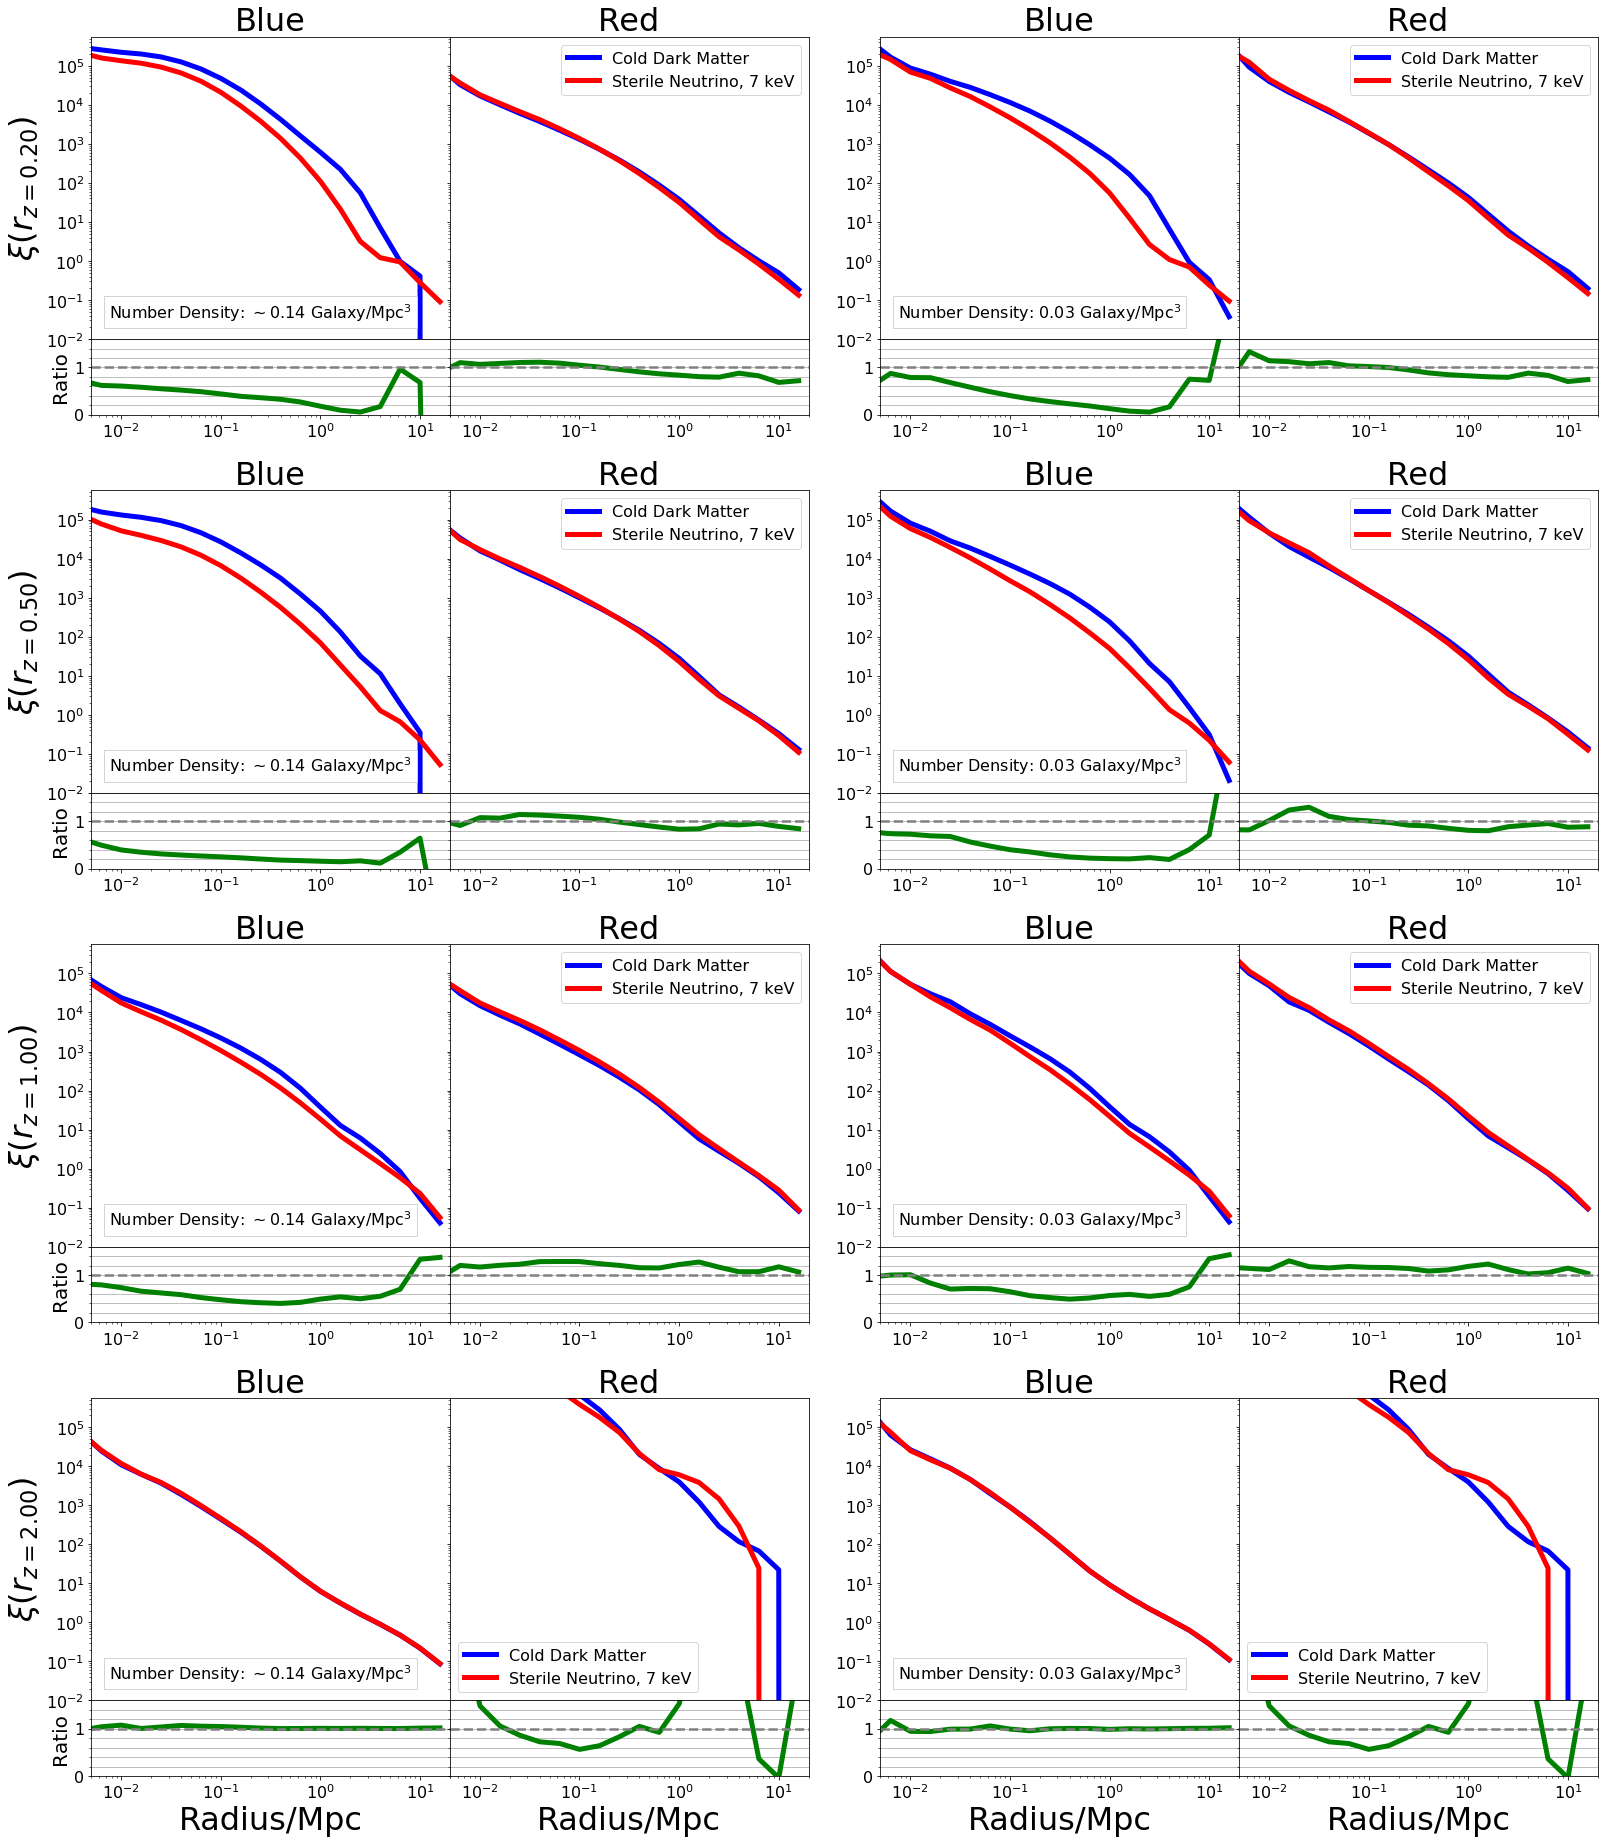

In [32]:
fig = plt.figure(figsize = (27, 32)) #28,40 #25,30
gs = gridspec.GridSpec(4, 2)

i=0
for z in [0.2,0.5,1.00,2.00]:
    
    z="{:.2f}".format(z)

    for n, n_text in zip([0.14,0.03],['$\sim$0.14','0.03']):
        
        n="{:.2f}".format(n)
        
        # load data
        CUTE_cdm_blue = np.genfromtxt("Output/redshift/corr_cdm_blue_galaxy_position_z"+z+"_n"+n+".txt")
        CUTE_wdm_blue = np.genfromtxt("Output/redshift/corr_wdm_blue_galaxy_position_z"+z+"_n"+n+".txt")
        
        CUTE_cdm_red = np.genfromtxt("Output/redshift/corr_cdm_red_galaxy_position_z"+z+"_n"+n+".txt")
        CUTE_wdm_red = np.genfromtxt("Output/redshift/corr_wdm_red_galaxy_position_z"+z+"_n"+n+".txt")
        
        textstr = r'Number Density: '+n_text+' Galaxy/Mpc$^{3}$'
        props = dict(facecolor='none', edgecolor='lightgrey', pad = 5.0)

        grid = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec = gs[i], hspace = 0, wspace = 0, 
                                                height_ratios=[4,1])
        
        # first grid
        grid0 = fig.add_subplot(grid[0])
        grid0.loglog(CUTE_cdm_blue[:,0], CUTE_cdm_blue[:,1], label = "Cold Dark Matter", linewidth = 5, 
                     color = "blue")
        grid0.loglog(CUTE_wdm_blue[:,0], CUTE_wdm_blue[:,1], label = "Sterile Neutrino, 7 keV", 
                     linewidth = 5, color = "red")
        grid0.text(0.05, 0.125, textstr, transform = grid0.transAxes, fontsize = 16, 
                   verticalalignment = 'top', bbox=props)
        grid0.set_title('Blue',fontsize=32)
        
        # second grid
        grid1 = fig.add_subplot(grid[1])
        grid1.loglog(CUTE_cdm_red[:,0], CUTE_cdm_red[:,1], label = "Cold Dark Matter", linewidth = 5, 
                     color = "blue")
        grid1.loglog(CUTE_wdm_red[:,0], CUTE_wdm_red[:,1], label = "Sterile Neutrino, 7 keV", 
                     linewidth = 5, color = "red")
        grid1.legend(fontsize = 16)
        grid1.set_title('Red',fontsize=32)

        # third grid
        grid2 = fig.add_subplot(grid[2], sharex=grid0)
        grid2.semilogx(CUTE_wdm_blue[:,0], CUTE_wdm_blue[:,1]/CUTE_cdm_blue[:,1], linewidth = 5, 
                       color = "green")
        
        # fourth grid
        grid3 = fig.add_subplot(grid[3])
        grid3.semilogx(CUTE_wdm_red[:,0], CUTE_wdm_red[:,1]/CUTE_cdm_red[:,1], linewidth = 5, 
                       color = "green")
        
        # details
        for grid in [grid0,grid1]:
            grid.set_ylim(10**-2, 10**5.75)
            
        for grid in [grid2,grid3]:
            grid.axhline(y = 1, color = "grey", ls = "--", linewidth = 2.5)
            grid.set_ylim(0, 1.6)
            grid.yaxis.grid(which = "both")
            
        for grid in [grid1,grid3]:
            grid.set_yticklabels([])
        
        for grid in [grid0,grid1,grid2,grid3]:
            grid.tick_params(labelsize=16)
            grid.set_xlim(5*10**-3, 2e1)
            grid.minorticks_on()
        
        if i%2==0:
            grid0.set_ylabel(r"$\xi(r_{z="+z+"})$", fontsize = 32)
            grid2.set_ylabel("Ratio", fontsize = 20)            
        if i>5:
            grid2.set_xlabel("Radius/Mpc", fontsize = 32)
            grid3.set_xlabel("Radius/Mpc", fontsize = 32)
        i+=1
    
gs.update(wspace=0.1) 
plt.show()

In [33]:
# loop through each redshift
for z in [0.2,0.5,1.00,2.00]:
    
    # and number density
    for n in [0.33,0.14,0.03]:
        
        # transfer the blue data to odyssey
        file1="blue_galaxy_position_z{:.2f}".format(z)+"_n{:.2f}".format(n)
        subsample(file1,'jackknife_'+file1,'Input\\redshift')
        
        # transfer the red data to odyssey
        file2="red_galaxy_position_z{:.2f}".format(z)+"_n{:.2f}".format(n)
        subsample(file2,'jackknife_'+file2,'Input\\redshift')

C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in subtract
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true

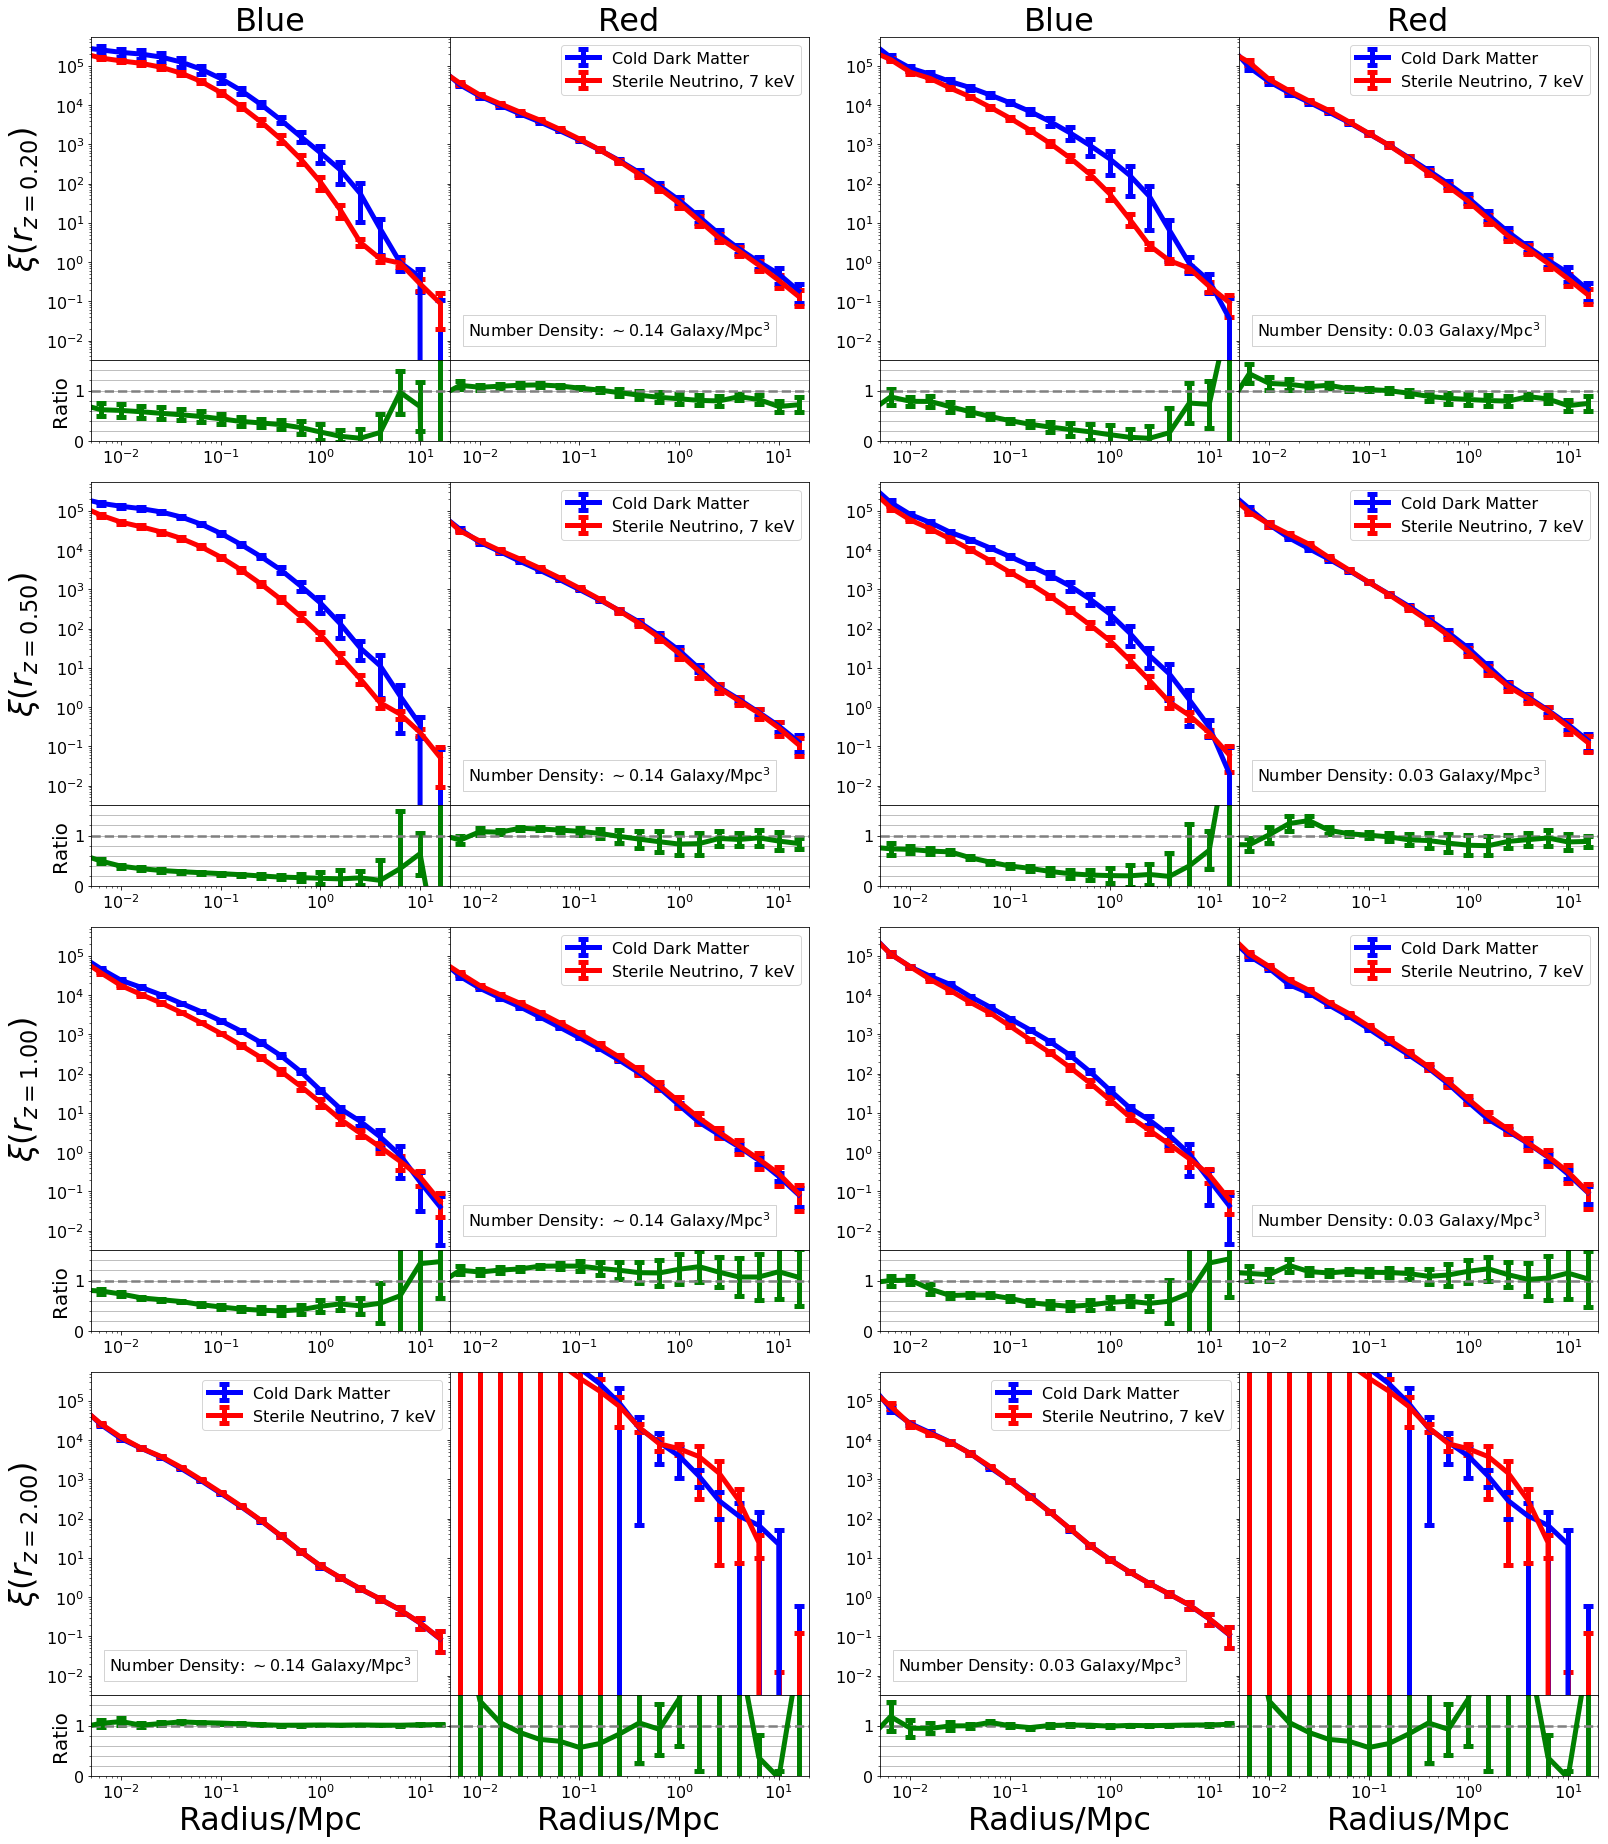

In [34]:
fig = plt.figure(figsize = (27, 32)) #28,40 #25,30
gs = gridspec.GridSpec(4, 2)

i=0
for z in [0.2,0.5,1.00,2.00]:
    
    z="{:.2f}".format(z)

    for n, n_text in zip([0.14,0.03],['$\sim$0.14','0.03']):
        
        n="{:.2f}".format(n)
        
        # load data
        CUTE_cdm_blue = np.genfromtxt("Output/redshift/corr_cdm_blue_galaxy_position_z"+z+"_n"+n+".txt")
        CUTE_wdm_blue = np.genfromtxt("Output/redshift/corr_wdm_blue_galaxy_position_z"+z+"_n"+n+".txt")
        
        CUTE_cdm_red = np.genfromtxt("Output/redshift/corr_cdm_red_galaxy_position_z"+z+"_n"+n+".txt")
        CUTE_wdm_red = np.genfromtxt("Output/redshift/corr_wdm_red_galaxy_position_z"+z+"_n"+n+".txt")\
        
        # transfer the blue errors from odyssey
        file_blue="blue_galaxy_position_z"+z+"_n"+n
        cdm_jackknife_blue,wdm_jackknife_blue,ratio_jackknife_blue=jackknife('jackknife_'+file_blue)
        
        # transfer the red errors from odyssey
        file_red="red_galaxy_position_z"+z+"_n"+n
        cdm_jackknife_red,wdm_jackknife_red,ratio_jackknife_red=jackknife('jackknife_'+file_red)
        
        # set up grids
        textstr = r'Number Density: '+n_text+' Galaxy/Mpc$^{3}$'
        props = dict(facecolor='none', edgecolor='lightgrey', pad = 5.0)
        grid = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec = gs[i], hspace = 0, wspace = 0, 
                                                height_ratios=[4,1])
        
        # first grid
        grid0 = fig.add_subplot(grid[0])
        grid0.errorbar(CUTE_cdm_blue[:,0], CUTE_cdm_blue[:,1], yerr = cdm_jackknife_blue, capsize = 5, 
                       capthick = 5, label = "Cold Dark Matter", linewidth = 5, color = "blue")
        grid0.errorbar(CUTE_wdm_blue[:,0], CUTE_wdm_blue[:,1], yerr = wdm_jackknife_blue, capsize = 5, 
                       capthick = 5, label = "Sterile Neutrino, 7 keV", linewidth = 5, color = "red")
        
        # second grid
        grid1 = fig.add_subplot(grid[1])
        grid1.errorbar(CUTE_cdm_red[:,0], CUTE_cdm_red[:,1], yerr = cdm_jackknife_red, capsize = 5, 
                       capthick = 5, label = "Cold Dark Matter", linewidth = 5, color = "blue")
        grid1.errorbar(CUTE_wdm_red[:,0], CUTE_wdm_red[:,1], yerr = wdm_jackknife_red, capsize = 5, 
                       capthick = 5, label = "Sterile Neutrino, 7 keV", linewidth = 5, color = "red")

        # third grid
        grid2 = fig.add_subplot(grid[2], sharex=grid0)
        grid2.errorbar(CUTE_cdm_blue[:,0], CUTE_wdm_blue[:,1]/CUTE_cdm_blue[:,1], capsize = 5,
                       yerr = ratio_jackknife_blue, capthick = 5, linewidth = 5, color = "green")
        
        # fourth grid
        grid3 = fig.add_subplot(grid[3])
        grid3.errorbar(CUTE_cdm_red[:,0], CUTE_wdm_red[:,1]/CUTE_cdm_red[:,1], capsize = 5,
                       yerr = ratio_jackknife_red, capthick = 5, linewidth = 5, color = "green")
        
        # details
        for grid in [grid0,grid1]:
            grid.set_ylim(10**-2.5, 10**5.75)
            grid.set_yscale("Log")
            
        for grid in [grid2,grid3]:
            grid.axhline(y = 1, color = "grey", ls = "--", linewidth = 2.5)
            grid.set_ylim(0, 1.6)
            grid.yaxis.grid(which = "both")
            
        for grid in [grid1,grid3]:
            grid.set_yticklabels([])
        
        for grid in [grid0,grid1,grid2,grid3]:
            grid.tick_params(labelsize=16)
            grid.set_xlim(5*10**-3, 2e1)
            grid.set_xscale("Log")
            grid.minorticks_on()
        
        if i<2:
            grid0.set_title('Blue',fontsize=32)
            grid1.set_title('Red',fontsize=32)
        if i%2==0:
            grid0.set_ylabel(r"$\xi(r_{z="+z+"})$", fontsize = 32)
            grid2.set_ylabel("Ratio", fontsize = 20)            
        if i>5:
            grid0.text(0.05, 0.125, textstr, transform = grid0.transAxes, fontsize = 16, 
                       verticalalignment = 'top', bbox=props)
            grid2.set_xlabel("Radius/Mpc", fontsize = 32)
            grid3.set_xlabel("Radius/Mpc", fontsize = 32)
            grid0.legend(fontsize = 16)
        else:
            grid1.text(1.05, 0.125, textstr, transform = grid0.transAxes, fontsize = 16, 
                       verticalalignment = 'top', bbox=props)
            grid1.legend(fontsize = 16)
        i+=1
    
gs.update(hspace = 0.1, wspace = 0.1) 
plt.savefig('Images/Summer2020/Redshift_Color_Jackknife.pdf')
plt.show()

### Figure A1

C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:113: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in true_divide


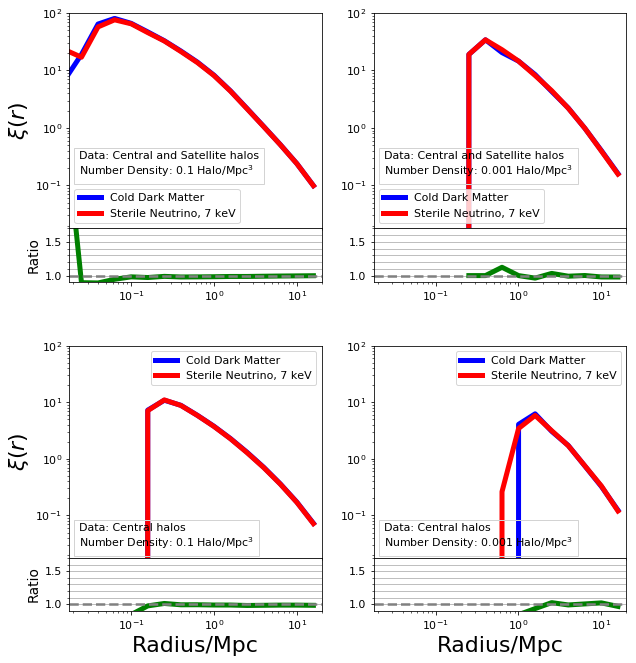

In [35]:
CUTE_cdm_sorted = np.genfromtxt("Output/corr_cdm_pos_sorted2.txt", usecols = (0,1))
CUTE_wdm_sorted = np.genfromtxt("Output/corr_wdm_pos_sorted2.txt", usecols = (0,1))

CUTE_cdm_sorted2 = np.genfromtxt("Output/corr_cdm_pos_sorted3.txt", usecols = (0,1))
CUTE_wdm_sorted2 = np.genfromtxt("Output/corr_wdm_pos_sorted3.txt", usecols = (0,1))

CUTE_cdm_sorted3 = np.genfromtxt("Output/corr_cdm_pos_sorted_centrals2.txt", usecols = (0,1))
CUTE_wdm_sorted3 = np.genfromtxt("Output/corr_wdm_pos_sorted_centrals2.txt", usecols = (0,1))

CUTE_cdm_sorted4 = np.genfromtxt("Output/corr_cdm_pos_sorted_centrals3.txt", usecols = (0,1))
CUTE_wdm_sorted4 = np.genfromtxt("Output/corr_wdm_pos_sorted_centrals3.txt", usecols = (0,1))

props = dict(facecolor='none', edgecolor='lightgrey', pad = 5.0)
textstr = '\n'.join((
    r'Data: Central and Satellite halos',
    r'Number Density: 0.1 Halo/Mpc$^{3}$'))
textstr2 = '\n'.join((
    r'Data: Central and Satellite halos',
    r'Number Density: 0.001 Halo/Mpc$^{3}$'))
textstr3 = '\n'.join((
    r'Data: Central halos',
    r'Number Density: 0.1 Halo/Mpc$^{3}$'))
textstr4 = '\n'.join((
    r'Data: Central halos',
    r'Number Density: 0.001 Halo/Mpc$^{3}$'))

plt.figure(figsize=(9,11))
grid0 = gridspec.GridSpec(2,1, height_ratios = [4,1])
grid0.update(hspace = 0, left=0.13, right=0.52, bottom = 0.54)
grid00 = plt.subplot(grid0[0])
grid01 = plt.subplot(grid0[1])

grid00.loglog(CUTE_cdm_sorted[:,0], CUTE_cdm_sorted[:,1], label = "Cold Dark Matter", linewidth = 5, 
              color = "blue")
grid00.loglog(CUTE_wdm_sorted[:,0], CUTE_wdm_sorted[:,1], label = "Sterile Neutrino, 7 keV", linewidth = 5, 
              color = "red")
grid00.set_ylabel(r"$\xi(r)$", fontsize = 22)
grid00.legend(fontsize = 11)
grid00.minorticks_on()
grid00.tick_params(labelsize=11)
grid00.text(0.04, 0.35, textstr, transform=grid00.transAxes, fontsize=11, verticalalignment='top', bbox=props)

grid01.semilogx(CUTE_wdm_sorted[:,0], CUTE_wdm_sorted[:,1]/CUTE_cdm_sorted[:,1],  linewidth = 5, 
                color = "green")
grid01.set_ylabel("Ratio", fontsize = 13.75)
grid01.axhline(y = 1, color = "grey", ls = "--", linewidth = 2.5)
grid01.minorticks_on()
grid01.tick_params(labelsize=11)
grid01.yaxis.grid(which = "both")

grid1 = gridspec.GridSpec(2,1, height_ratios = [4,1])
grid1.update(hspace = 0, left=0.6, right=0.99, bottom = 0.54)
grid10 = plt.subplot(grid1[0])
grid11 = plt.subplot(grid1[1])

grid10.loglog(CUTE_cdm_sorted2[:,0], CUTE_cdm_sorted2[:,1], label = "Cold Dark Matter",  linewidth = 5, 
              color = "blue")
grid10.loglog(CUTE_wdm_sorted2[:,0], CUTE_wdm_sorted2[:,1], label = "Sterile Neutrino, 7 keV",  linewidth = 5,
              color = "red")
grid10.legend(fontsize = 11)
grid10.minorticks_on()
grid10.tick_params(labelsize=11)
grid10.text(0.04, 0.35, textstr2, transform = grid10.transAxes, fontsize = 11, verticalalignment = 'top', 
            bbox = props)

grid11.semilogx(CUTE_wdm_sorted2[:,0], CUTE_wdm_sorted2[:,1]/CUTE_cdm_sorted2[:,1],  linewidth = 5, 
                color = "green")
grid11.axhline(y = 1, color = "grey", ls = "--", linewidth = 2.5)
grid11.minorticks_on()
grid11.tick_params(labelsize=11)
grid11.yaxis.grid(which = "both")

grid2 = gridspec.GridSpec(2,1, height_ratios = [4,1])
grid2.update(hspace = 0, left=0.13, right=0.52, top = 0.46)
grid20 = plt.subplot(grid2[0])
grid21 = plt.subplot(grid2[1])

grid20.loglog(CUTE_cdm_sorted3[:,0], CUTE_cdm_sorted3[:,1], label = "Cold Dark Matter",  linewidth = 5, 
              color = "blue")
grid20.loglog(CUTE_wdm_sorted3[:,0], CUTE_wdm_sorted3[:,1], label = "Sterile Neutrino, 7 keV",  linewidth = 5,
              color = "red")
grid20.set_ylabel(r"$\xi(r)$", fontsize = 22)
grid20.legend(fontsize = 11)
grid20.minorticks_on()
grid20.tick_params(labelsize=11)
grid20.text(0.04, 0.155, textstr3, transform = grid20.transAxes, fontsize = 11, verticalalignment = 'top', 
            bbox = props)

grid21.semilogx(CUTE_wdm_sorted3[:,0], CUTE_wdm_sorted3[:,1]/CUTE_cdm_sorted3[:,1],  linewidth = 5, 
                color = "green")
grid21.set_xlabel("Radius/Mpc", fontsize = 22)
grid21.set_ylabel("Ratio", fontsize = 13.75)
grid21.axhline(y = 1, color = "grey", ls = "--", linewidth = 2.5)
grid21.minorticks_on()
grid21.tick_params(labelsize=11)
grid21.yaxis.grid(which = "both")

grid3 = gridspec.GridSpec(2,1, height_ratios = [4,1])
grid3.update(hspace = 0, left=0.6, right=0.99, top = 0.46)
grid30 = plt.subplot(grid3[0])
grid31 = plt.subplot(grid3[1])

grid30.loglog(CUTE_cdm_sorted4[:,0], CUTE_cdm_sorted4[:,1], label = "Cold Dark Matter",  linewidth = 5, 
              color = "blue")
grid30.loglog(CUTE_wdm_sorted4[:,0], CUTE_wdm_sorted4[:,1], label = "Sterile Neutrino, 7 keV",  linewidth = 5,
              color = "red")
grid30.legend(fontsize = 11)
grid30.minorticks_on()
grid30.tick_params(labelsize=11)
grid30.text(0.04, 0.155, textstr4, transform = grid30.transAxes, fontsize = 11, verticalalignment = 'top', 
            bbox = props)

grid31.semilogx(CUTE_wdm_sorted4[:,0], CUTE_wdm_sorted4[:,1]/CUTE_cdm_sorted4[:,1],  linewidth = 5, 
                color = "green")
grid31.set_xlabel("Radius/Mpc", fontsize = 22)
grid31.axhline(y = 1, color = "grey", ls = "--", linewidth = 2.5)
grid31.minorticks_on()
grid31.tick_params(labelsize=11)
grid31.yaxis.grid(which = "both")

for grid in [grid00, grid01, grid10, grid11, grid20, grid21, grid30, grid31]:
    grid.set_xlim(10**-1.75, 2e1)
    grid.set_ylim(10**-1.75, 10**2)

for grid in [grid01, grid11, grid21, grid31]:
    grid.set_ylim(0.9, 1.7)

plt.show()

In [36]:
# Send it to odyssey
for file in ['pos_sorted2','pos_sorted3','pos_sorted_centrals2','pos_sorted_centrals3']:
    subsample(file,'jackknife_'+file)

C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in subtract
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide


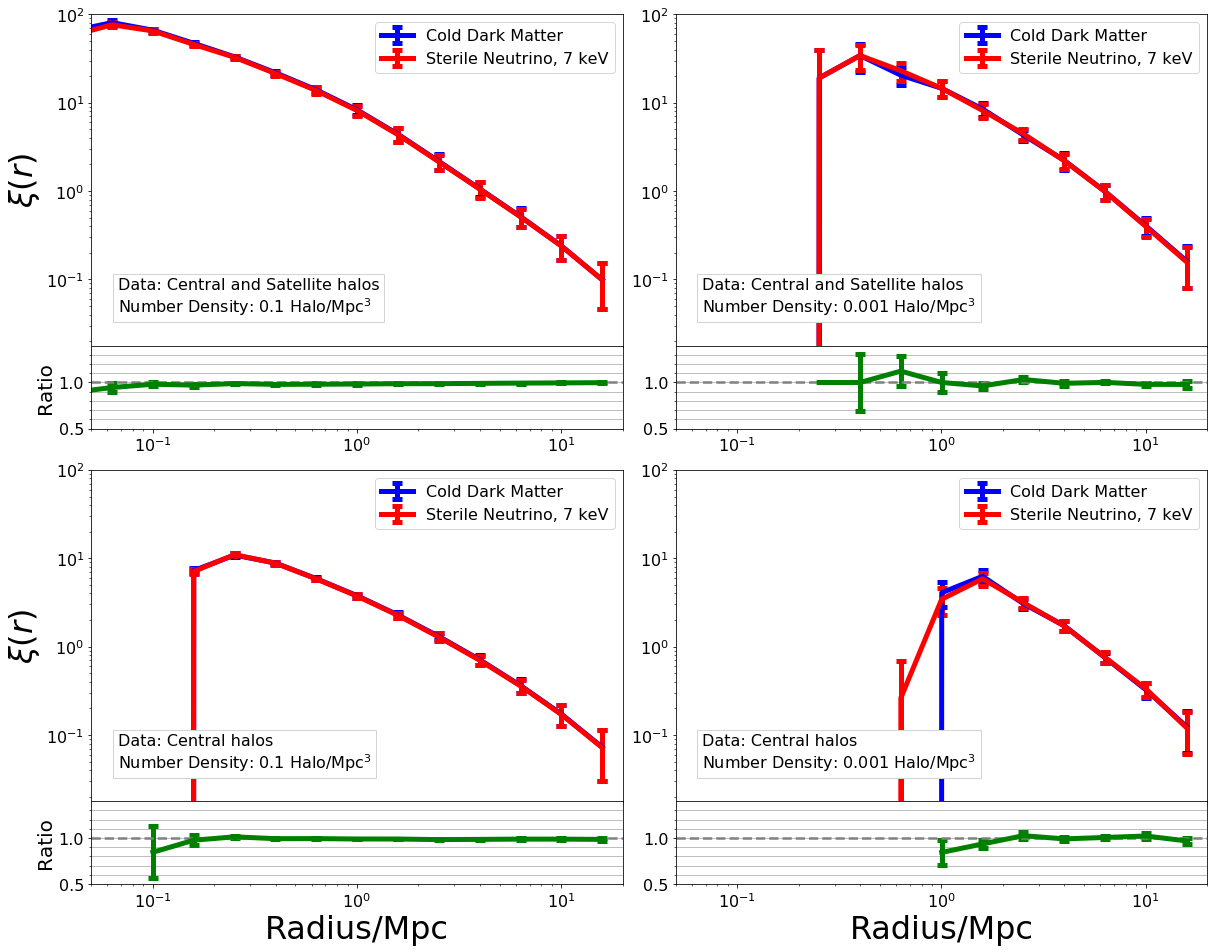

In [37]:
fig = plt.figure(figsize = (20,16))
gs = gridspec.GridSpec(2, 2)
props = dict(facecolor='white', edgecolor='lightgrey', pad = 5.0)

files=['pos_sorted2','pos_sorted3','pos_sorted_centrals2','pos_sorted_centrals3']
satellite=[' and Satellite ',' and Satellite ',' ',' ']
n=[0.1, 0.001, 0.1, 0.001]

for i in range(4):
    
    file=files[i]
    CUTE_cdm_sorted=np.genfromtxt("Output/corr_cdm_"+file+".txt", usecols = (0,1))
    CUTE_wdm_sorted=np.genfromtxt("Output/corr_wdm_"+file+".txt", usecols = (0,1))
    cdm_jackknife,wdm_jackknife,ratio_jackknife=jackknife('jackknife_'+file)

    grid = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = gs[i], hspace = 0, wspace = 0, 
                                            height_ratios = [4,1])
    textstr = '\n'.join((
    r'Data: Central'+satellite[i]+'halos',
    r'Number Density: '+np.str(n[i])+' Halo/Mpc$^{3}$'))
    grid0 = fig.add_subplot(grid[0])
    grid1 = fig.add_subplot(grid[1])

    grid0.errorbar(CUTE_cdm_sorted[:,0], CUTE_cdm_sorted[:,1], yerr = cdm_jackknife, 
                   capsize = 5, capthick = 5, label = "Cold Dark Matter", linewidth = 5, color = "blue")
    grid0.errorbar(CUTE_wdm_sorted[:,0], CUTE_wdm_sorted[:,1], yerr = wdm_jackknife, 
                   capsize = 5, capthick = 5, label = "Sterile Neutrino, 7 keV", linewidth = 5, color = "red")
    grid0.text(0.05, 0.2, textstr, transform = grid0.transAxes, fontsize = 16, verticalalignment = 'top', 
               bbox = props)
    grid0.set_ylim(10**-1.75,10**2)
    grid0.legend(fontsize = 16)
    grid0.set_yscale("Log")

    grid1.errorbar(CUTE_wdm_sorted[:,0], CUTE_wdm_sorted[:,1]/CUTE_cdm_sorted[:,1], 
                   yerr = ratio_jackknife, capsize = 5, capthick = 5, linewidth = 5, color = "green")
    grid1.axhline(y = 1, color = "grey", ls = "--", linewidth = 2.5)
    grid1.yaxis.grid(which = "both")
    grid1.set_ylim(0.5, 1.4)

    for grid in [grid0,grid1]:
        grid.set_xlim(0.5*10**-1,2e1)
        grid.tick_params(labelsize=16)
        grid.set_xscale("Log")
        grid.minorticks_on()
        
    if i%2==0:
        grid0.set_ylabel(r"$\xi(r)$", fontsize = 32)
        grid1.set_ylabel("Ratio", fontsize = 20)
    if i>1:
        grid1.set_xlabel('Radius/Mpc', fontsize = 32)

gs.update(hspace = 0.1, wspace = 0.1)
plt.savefig('Images/Summer2020/Halos.pdf')
plt.show()